# Assignment 2
The objective of this assignment is to introduce you to function specific neural networks. In otherwords, we will try and design neural networks based on insights from existing optimization algorithms. In the process, you will realize that while deep neural networks can, in theory, be generalized to learn arbitrary functions, design choices determine how easily and quickly they are able to learn those functions.

Additionally, when the training process starts, the model has to learn a particular mapping with no prior hint about the kind of function it is looking for. By introducing a structure which correlates to optimization objectives, neural networks can effectively be helped in narrowing done the choice of functions and parameters to be learnt.

### Imports

Name: Jawad Saeed

Roll Number: 25100094

Name: Muhammad Saad Haroon

Roll Number: 25100147

Name: Daanish Uddin Khan

Roll Number: 25100004



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from scipy import stats
import torch
import pickle
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
# from google.colab import drive

np.random.seed(0)
gen = torch.Generator().manual_seed(0)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 1: Sparsity and Robustness

Please add your solution to this task from the manual in the cells below.

#### L2 Norm Minimized Form

In [ ]:
# Declaring the array of observations for calculating the norms
x = np.array([1, 1, 1, 6, 1, 1])

# The minimzation of the L2-norm is basically the mean of the provided data
z_hat_l2 = np.mean(x)

print("The minimized value of the L2 norm is ", z_hat_l2)

The minimized value of the L2 norm is  1.8333333333333333


#### L1 Norm Minimized Form

In [ ]:
# The minimization of the L2-norm corresponds to the median value of the input data
z_hat_l1 = np.median(x)

print("The minimized value of the L1 norm is", z_hat_l1)

The minimized value of the L1 norm is 1.0


#### L0 Norm Minimized Form

In [ ]:
# The minimization of the L0-Norm corresponds to the mode of the input data
z_hat_l0 = stats.mode(x)

print("The minimized value of the L0 norm is:", z_hat_l0[0])

The minimized value of the L0 norm is: 1


From the results above it is visible that L1 Norm and L0 Norm are both robust to the outlier value of 6 in the input data.

# Task 2: Sparsity in Contrastive Models

Please add your solution to this task from the manual in the cells below.

### 1. Classification Using Similarity Between Text and Image Embeddings

Step 1: Load in the model and Dataset

In [ ]:
import torch
from transformers import CLIPModel, CLIPProcessor
import torchvision.datasets as datasets
import random
import matplotlib.pyplot as plt

# Load the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Load dataset
dataset = datasets.CIFAR10(root="./data", download=True, train=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


100%|██████████| 170498071/170498071 [00:03<00:00, 43087855.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Step 2: Generate Dense Embeddings

In [ ]:
# Function to generate dense image embeddings
def get_image_embedding(image):
    # Preprocess the image and convert it to a tensor
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features / image_features.norm(dim=-1, keepdim=True)

# Generate text embeddings for each class label
text_inputs = processor(text=[f"a photo of a {c}" for c in dataset.classes], return_tensors="pt").to(device)
with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

In [ ]:
import random
import matplotlib.pyplot as plt

# Function to generate dense image embeddings
def get_image_embedding(image):
    # Preprocess the image and convert it to a tensor
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features / image_features.norm(dim=-1, keepdim=True)

# Generate text embeddings for each class label
text_inputs = processor(text=[f"a photo of a {c}" for c in dataset.classes], return_tensors="pt").to(device)
with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

Step 3: Zero-Shot Classification

Random Index: 3440
Predicted class: bird
True label: bird


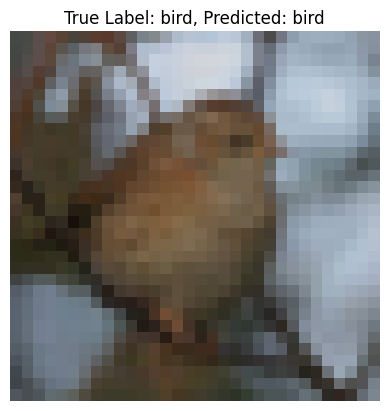

In [ ]:
# Get the random image and its label
random_index = random.randint(0, len(dataset) - 1)
image, label = dataset[random_index]

# Get image embedding
image_features = get_image_embedding(image)

# Calculate cosine similarity between the image embedding and the text embeddings
similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
predicted_class = similarities.argmax(dim=-1)

# Print the predicted class and the true label
print(f"Random Index: {random_index}")
print(f"Predicted class: {dataset.classes[predicted_class.item()]}")
print(f"True label: {dataset.classes[label]}")

# Display the randomly selected image
plt.imshow(image)
plt.title(f"True Label: {dataset.classes[label]}, Predicted: {dataset.classes[predicted_class.item()]}")
plt.axis("off")  # Turn off axis labels
plt.show()

### 2. Generating Concept Dictionary Using FLICKR-30k

Step 1: Loading Flickr-30k

In [ ]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# Load Flickr-30k Dataset
ds = load_dataset("lmms-lab/flickr30k")

README.md:   0%|          | 0.00/2.23k [00:00<?, ?B/s]

test-00000-of-00009.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

test-00001-of-00009.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

test-00002-of-00009.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

test-00003-of-00009.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

test-00004-of-00009.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

test-00005-of-00009.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

test-00006-of-00009.parquet:   0%|          | 0.00/528M [00:00<?, ?B/s]

test-00007-of-00009.parquet:   0%|          | 0.00/511M [00:00<?, ?B/s]

test-00008-of-00009.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/31783 [00:00<?, ? examples/s]

In [ ]:
import re

# Function to extract single-word concepts from captions
def extract_concepts(captions, max_concepts=100):
    words = []
    for caption in captions:
        # Remove non-alphabetic characters and split into words
        words += re.findall(r'\b\w+\b', caption.lower())

    # Filter out non-unique words and limit to max_concepts
    unique_words = list(set(words))
    return unique_words[:max_concepts]  # Limiting to most frequent concepts

# Flatten all captions into a single list of strings
captions = [caption for item in ds['test'] for caption in item['caption']]  # Flattening all captions

# Extract concepts (common words) from captions
concepts = extract_concepts(captions)

# Generate concept embeddings using CLIP's text encoder
text_inputs = processor(text=concepts, return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    concept_embeddings = model.get_text_features(**text_inputs)
    concept_embeddings /= concept_embeddings.norm(dim=-1, keepdim=True)  # Normalize embeddings

# The matrix A, where each column is a concept embedding
A = concept_embeddings.T  # Transpose to match A in the form of Rdxc

# Output the shape of the concept matrix
print(f"Shape of the concept dictionary A: {A.shape}")
print(f"Sample concepts: {concepts[:10]}")

Shape of the concept dictionary A: torch.Size([768, 100])
Sample concepts: ['boa', 'shaded', 'shows', 'steph', 'poi', 'bratwurst', 'lying', 'pitbulls', 'style', 'stockcar']


### 3. Aligning Image and Text Embeddings

In [ ]:
import torch.nn.functional as F

# Get a random image from the Flickr-30k dataset
random_index = random.randint(0, len(ds['test']) - 1)
random_image = ds['test'][random_index]['image']  # Get the random image from the dataset

# Generate image embeddings for the selected image
image_embedding = get_image_embedding(random_image)

# Step 2: Compute the mean of the image embeddings and the concept dictionary embeddings
# Mean of image embeddings
image_mean = image_embedding.mean(dim=0, keepdim=True)

# Mean of concept dictionary (from Task 2 Step 2)
concept_mean = A.mean(dim=1, keepdim=True)

# Step 3: Center the embeddings
centered_image_embedding = image_embedding - image_mean
centered_concept_embeddings = A - concept_mean

# Step 4: Normalize the embeddings
normalized_image_embedding = F.normalize(centered_image_embedding, dim=-1)
normalized_concept_embeddings = F.normalize(centered_concept_embeddings, dim=-1)

# Output shapes to confirm alignment
print(f"Shape of normalized image embedding: {normalized_image_embedding.shape}")
print(f"Shape of normalized concept embeddings: {normalized_concept_embeddings.shape}")
print(f"Random Image Index: {random_index}")

Shape of normalized image embedding: torch.Size([1, 768])
Shape of normalized concept embeddings: torch.Size([768, 100])
Random Image Index: 939


### 4. Solving The Optimisation Problem

In [ ]:
from sklearn.linear_model import Lasso

# Step 1: Solve the optimization problem to get the sparse weight vector w

# Convert tensors to numpy arrays for use with sklearn
centered_image_embedding_np = centered_image_embedding.cpu().numpy()
centered_concept_embeddings_np = centered_concept_embeddings.cpu().numpy()

# Set regularization parameter lambda
lambda_val = 0.0025  # You can tune this parameter

# Lasso regression to solve for w (L1 regularization)
lasso = Lasso(alpha=lambda_val)
lasso.fit(centered_concept_embeddings_np, centered_image_embedding_np.squeeze())  # Solve for w
w = torch.tensor(lasso.coef_).to(device)  # Convert w back to a tensor

# Step 2: Reconstruct the sparse representation of the image embedding
sparse_image_embedding = torch.matmul(A, w.unsqueeze(1)) + concept_mean

# Output the shapes and a sample of the sparse vector
print(f"Shape of sparse image embedding: {sparse_image_embedding.shape}")
print(f"Sparse image embedding (first 10 values): {sparse_image_embedding[:10]}")

Shape of sparse image embedding: torch.Size([768, 1])
Sparse image embedding (first 10 values): tensor([[ 0.0085],
        [ 0.0032],
        [ 0.0158],
        [-0.0161],
        [ 0.0027],
        [ 0.0062],
        [ 0.0096],
        [-0.0028],
        [ 0.0110],
        [-0.0007]], device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


### 5. Zero-Shot Classification on a random image using both dense and sparse embeddings

True Caption: Two people with backpacks hike up a rocky dirt path next to a conifer tree .


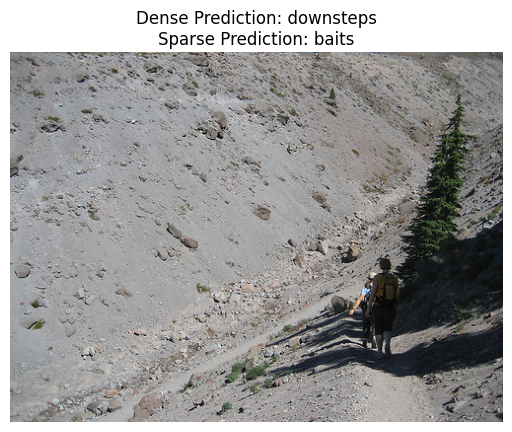

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Step 1: Compute cosine similarity for dense embeddings
dense_similarity = F.cosine_similarity(image_embedding, A.T, dim=-1)

# Step 2: Ensure proper dimensions for sparse embeddings before cosine similarity
sparse_image_embedding = sparse_image_embedding.squeeze(1)  # Remove the extra dimension
sparse_similarity = F.cosine_similarity(sparse_image_embedding.unsqueeze(0), A.T, dim=-1)

# Step 3: Get the predicted class for dense embeddings
dense_predicted_class_idx = dense_similarity.argmax().item()
dense_predicted_class = concepts[dense_predicted_class_idx]

# Step 4: Get the predicted class for sparse embeddings
sparse_predicted_class_idx = sparse_similarity.argmax().item()
sparse_predicted_class = concepts[sparse_predicted_class_idx]

# Step 5: Get the true label of the image
true_caption = ds['test'][random_index]['caption'][0]  # First caption of the randomly selected image

# Step 6: Display the image
print(f"True Caption: {true_caption}")
plt.imshow(random_image)
plt.title(f"Dense Prediction: {dense_predicted_class}\nSparse Prediction: {sparse_predicted_class}")
plt.axis("off")
plt.show()


### 6. Comparing Dense vs Sparse Accuracy for CIFAR-10
Step 1: Loading in the model and dataset

In [ ]:
import torch
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
from scipy.sparse import csr_matrix
import sys

# Load the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Load CIFAR-10 dataset
cifar10 = load_dataset("cifar10")

# Define CIFAR-10 classes
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# Process CIFAR-10 images and labels
def preprocess_images(dataset, max_images=None):
    images = []
    labels = []
    for i, example in enumerate(dataset):
        if max_images and i >= max_images:
            break
        img = example['img']
        images.append(img)
        labels.append(example['label'])
    return images, labels

# Preprocess Images
images, true_labels = preprocess_images(cifar10['test'], max_images=None)

Generating Image Embeddings of Entire Dataset

In [ ]:
# Process the dataset in batches and obtain dense image embeddings
def process_in_batches(batch_size, images, model, processor, device):
    z_img_dense_list = []
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]
        inputs = processor(images=batch_images, return_tensors="pt", padding=True).to(device)

        # Compute dense image embeddings in batches
        with torch.no_grad():
            z_img_dense = model.get_image_features(**inputs)
        z_img_dense_list.append(z_img_dense.cpu().numpy())

    # Concatenate all batches and normalize dense embeddings
    z_img_dense = np.concatenate(z_img_dense_list, axis=0)
    z_img_dense_normalized = z_img_dense / np.linalg.norm(z_img_dense, axis=1, keepdims=True)

    return z_img_dense_normalized

batch_size = 100  # Adjust batch size according to your GPU memory
z_img_dense_normalized = process_in_batches(batch_size, images, model, processor, device)
print(f"Image Embeddings Shape: {z_img_dense_normalized.shape}")

Image Embeddings Shape: (10000, 768)


Creating CIFAR-10 Concept Dictionary

In [ ]:
# Create a concept dictionary using CIFAR-10 class names
def get_class_embeddings(class_labels):
    inputs = processor(text=class_labels, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        class_embeddings = model.get_text_features(**inputs)
    return class_embeddings.cpu().numpy()

A_centered_normalized = get_class_embeddings(cifar10_classes)

print(f"Concept Dictionary Shape: {A_centered_normalized.T.shape}")

Concept Dictionary Shape: (768, 10)


Functions to Induce Sparsity and Normalise the Resulting Sparse Images

In [ ]:
# Function to store sparse embeddings using a sparse weight matrix format
def lasso_sparse_reconstruction(z_img_dense_normalized, A_centered_normalized, alpha):
    lasso = Lasso(alpha=alpha, fit_intercept=False)
    sparse_reconstructed_images = []

    for dense_embedding in z_img_dense_normalized:
        lasso.fit(A_centered_normalized.T, dense_embedding)  # Fit Lasso
        w_sparse = lasso.coef_  # Sparse weight vector (size: 10)

        # Reconstruct sparse embedding in 768-dimensional space
        sparse_image = A_centered_normalized.T @ w_sparse  # This should give a (768,) embedding

        # Convert the result to sparse matrix format for efficiency
        sparse_matrix = csr_matrix(sparse_image)  # Convert to sparse matrix format
        sparse_reconstructed_images.append(sparse_matrix)

    return sparse_reconstructed_images  # Return list of sparse matrices

def normalize_sparse_images(sparse_images):
    normalized_images = []
    for sparse_image in sparse_images:
        dense_image = sparse_image.toarray().flatten()  # Convert to dense for normalization
        norm = np.linalg.norm(dense_image) + 1e-8  # Prevent division by zero
        normalized_dense = dense_image / norm  # Normalize the dense image
        sparse_normalized = csr_matrix(normalized_dense)  # Convert back to sparse matrix format
        normalized_images.append(sparse_normalized)
    return normalized_images

# Convert normalized sparse embeddings to dense for cosine similarity
def sparse_to_dense(sparse_matrices):
    return np.array([sparse_matrix.toarray().flatten() for sparse_matrix in sparse_matrices])

# Sparsity
sparse_reconstructed_images = lasso_sparse_reconstruction(z_img_dense_normalized, A_centered_normalized, alpha=0.0055)

# Normalize the sparse embeddings
sparse_reconstructed_images_normalized = normalize_sparse_images(sparse_reconstructed_images)

sparse_reconstructed_images_dense = sparse_to_dense(sparse_reconstructed_images_normalized)

print(f"Number of Images: {len(sparse_reconstructed_images)}")
print(f"Sparse Reconstructed Images Dense: {sparse_reconstructed_images_dense[0]}")

Number of Images: 10000
Sparse Reconstructed Images Dense: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Dense vs Sparse Accuracy For Sparse Alpha = 0.0055

In [ ]:
# Compute cosine similarity for dense embeddings
dense_cosine_similarities = cosine_similarity(z_img_dense_normalized, A_centered_normalized)
dense_predictions = np.argmax(dense_cosine_similarities, axis=1)
dense_accuracy = accuracy_score(true_labels, dense_predictions)

# Compute cosine similarity for sparse embeddings (images to class embeddings)
sparse_cosine_similarities = cosine_similarity(sparse_reconstructed_images_dense, A_centered_normalized)
sparse_predictions = np.argmax(sparse_cosine_similarities, axis=1)
sparse_accuracy = accuracy_score(true_labels, sparse_predictions)

print(f"Accuracy of Zero-Shot Classification (Dense Embeddings): {dense_accuracy * 100:.2f}%")
print(f"Accuracy of Zero-Shot Classification (Sparse Embeddings): {sparse_accuracy * 100:.2f}%")

Accuracy of Zero-Shot Classification (Dense Embeddings): 91.43%
Accuracy of Zero-Shot Classification (Sparse Embeddings): 23.50%


Calculating and Displaying Memory Footprint and Sparsity Level

In [ ]:
# Memory
def memory_footprint(embeddings):
    return sys.getsizeof(embeddings) / (1024 * 1024)  # Convert to MB

# Memory footprint for sparse matrices
def sparse_memory_footprint(sparse_matrices):
    total_memory = 0
    for sparse_matrix in sparse_matrices:
        if isinstance(sparse_matrix, csr_matrix):
            total_memory += sparse_matrix.data.nbytes  # Memory used by sparse data
    return total_memory / (1024 * 1024)  # Convert to MB

def calculate_sparsity(sparse_matrices):
    total_elements = 0
    non_zero_elements = 0

    for sparse_matrix in sparse_matrices:
        if isinstance(sparse_matrix, csr_matrix):
            total_elements += sparse_matrix.shape[0] * sparse_matrix.shape[1]
            non_zero_elements += sparse_matrix.nnz  # Number of non-zero elements in the sparse matrix

    sparsity = 100 * (1 - non_zero_elements / total_elements)
    return sparsity

dense_memory = memory_footprint(z_img_dense_normalized)
sparse_memory = sparse_memory_footprint(sparse_reconstructed_images)
sparse_sparsity = calculate_sparsity(sparse_reconstructed_images)

print(f"Memory footprint of dense embeddings: {dense_memory:.2f} MB")
print(f"Memory footprint of sparse embeddings: {sparse_memory:.2f} MB")
print(f"Sparsity in sparse embeddings: {sparse_sparsity:.2f}%")

Memory footprint of dense embeddings: 29.30 MB
Memory footprint of sparse embeddings: 4.03 MB
Sparsity in sparse embeddings: 86.26%


Visualising Sparsity Level vs Zero-Shot Accuracy for different alpha values

Testing with alpha = 0.004
Accuracy of Zero-Shot Classification (Sparse Embeddings): 84.39%
Memory footprint of sparse embeddings: 27.81 MB
Sparsity in sparse embeddings: 5.06%

Testing with alpha = 0.0045
Accuracy of Zero-Shot Classification (Sparse Embeddings): 79.78%
Memory footprint of sparse embeddings: 22.89 MB
Sparsity in sparse embeddings: 21.87%

Testing with alpha = 0.005
Accuracy of Zero-Shot Classification (Sparse Embeddings): 56.13%
Memory footprint of sparse embeddings: 14.16 MB
Sparsity in sparse embeddings: 51.67%

Testing with alpha = 0.00525
Accuracy of Zero-Shot Classification (Sparse Embeddings): 38.43%
Memory footprint of sparse embeddings: 8.58 MB
Sparsity in sparse embeddings: 70.73%



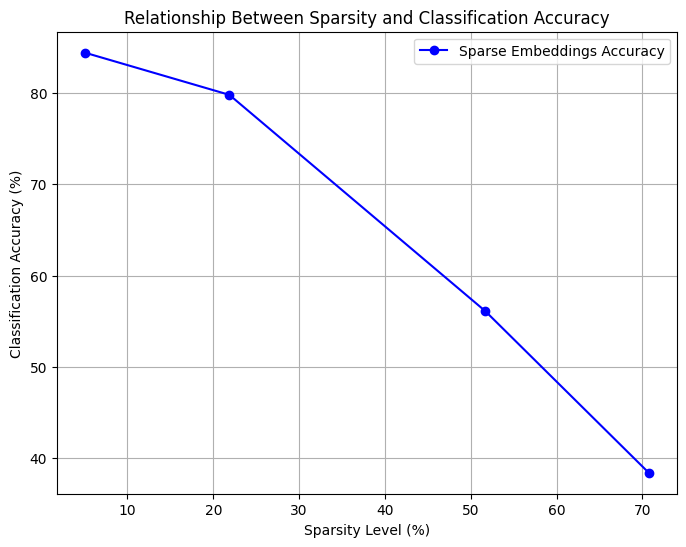

In [ ]:
import matplotlib.pyplot as plt

# Example alpha values to test sparsity and accuracy
alpha_values = [0.004, 0.0045, 0.005, 0.00525]

# Initialize lists to collect sparsity and accuracy data
sparsity_levels = []
accuracy_sparse = []

for alpha in alpha_values:
    print(f"Testing with alpha = {alpha}")

    # Step 1: Lasso to generate sparse embeddings
    sparse_reconstructed_images = lasso_sparse_reconstruction(z_img_dense_normalized, A_centered_normalized, alpha=alpha)

    # Normalize the sparse embeddings
    sparse_reconstructed_images_normalized = normalize_sparse_images(sparse_reconstructed_images)

    # Convert normalized sparse embeddings to dense for cosine similarity
    def sparse_to_dense(sparse_matrices):
        return np.array([sparse_matrix.toarray().flatten() for sparse_matrix in sparse_matrices])

    sparse_reconstructed_images_dense = sparse_to_dense(sparse_reconstructed_images_normalized)

    # Compute cosine similarity for sparse embeddings (images to class embeddings)
    sparse_cosine_similarities = cosine_similarity(sparse_reconstructed_images_dense, A_centered_normalized)
    sparse_predictions = np.argmax(sparse_cosine_similarities, axis=1)
    sparse_accuracy = accuracy_score(true_labels, sparse_predictions)

    # Calculate memory footprint and sparsity
    sparse_memory = sparse_memory_footprint(sparse_reconstructed_images)
    sparse_sparsity = calculate_sparsity(sparse_reconstructed_images)

    # Print results
    print(f"Accuracy of Zero-Shot Classification (Sparse Embeddings): {sparse_accuracy * 100:.2f}%")
    print(f"Memory footprint of sparse embeddings: {sparse_memory:.2f} MB")
    print(f"Sparsity in sparse embeddings: {sparse_sparsity:.2f}%")
    print()

    # Collect sparsity and accuracy data for plotting
    sparsity_levels.append(sparse_sparsity)
    accuracy_sparse.append(sparse_accuracy * 100)

# Plot the relationship between sparsity and classification accuracy
plt.figure(figsize=(8, 6))
plt.plot(sparsity_levels, accuracy_sparse, marker='o', linestyle='-', color='b', label='Sparse Embeddings Accuracy')
plt.title("Relationship Between Sparsity and Classification Accuracy")
plt.xlabel("Sparsity Level (%)")
plt.ylabel("Classification Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

## Visualising top contributing concepts using random exmaples from CIFAR-10

### Why are non-related classes contributing so much?

The dictionary
𝐴
 is trained to capture generic features that are relevant across multiple classes. Many visual patterns (edges, textures, shapes) are shared among classes, which explains why unrelated classes can still have high similarity scores.
For example, "bird" and "horse" may share features related to the general shape of the body or textures that the model finds useful in distinguishing these animals, even though the images belong to different classes. Similarly, "frog" might contribute due to texture similarities (smooth, natural surfaces) with the "bird" class.
The lasso reconstruction algorithm aims for a sparse representation, meaning that it selects only a few atoms (concepts) to represent the image. If these atoms are shared across multiple classes, this leads to high similarity for those classes even if they are not the true label.

### Confusion due to shared visual features:

Classes like "horse," "frog," and "deer" all belong to the animal category, where certain visual traits like organic shapes, fur-like textures, or background similarities can overlap. This can cause confusion in sparse embeddings when a "bird" image is being reconstructed, as it may activate visual patterns similar to those found in other animal classes.
The "ship" class might seem out of place, but it’s possible that parts of the image (e.g., background patterns, structural edges) are similar to the hull or deck of a ship, leading to its inclusion in the top contributing classes.


Image 6079:


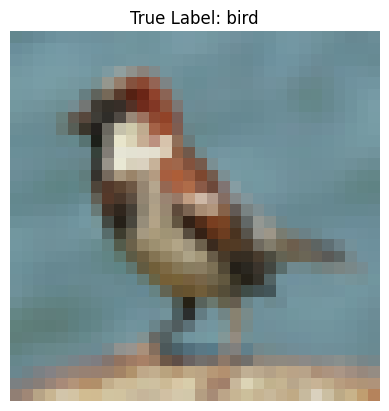

Top contributing classes:
Class: bird, Similarity: 1.0000
Class: horse, Similarity: 0.8270
Class: frog, Similarity: 0.8237
Class: ship, Similarity: 0.8091
Class: deer, Similarity: 0.8033

Image 6457:


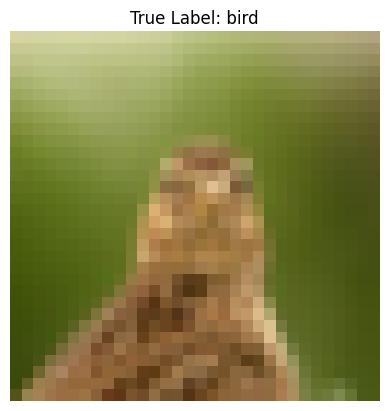

Top contributing classes:
Class: bird, Similarity: 1.0000
Class: horse, Similarity: 0.8270
Class: frog, Similarity: 0.8237
Class: ship, Similarity: 0.8091
Class: deer, Similarity: 0.8033

Image 1652:


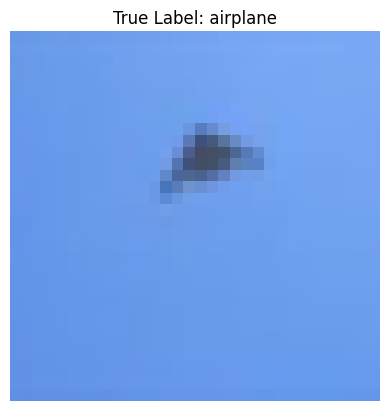

Top contributing classes:
Class: bird, Similarity: 1.0000
Class: horse, Similarity: 0.8270
Class: frog, Similarity: 0.8237
Class: ship, Similarity: 0.8091
Class: deer, Similarity: 0.8033


In [ ]:
# Function to get the top contributing classes
def get_top_contributing_classes(sparse_embedding, class_embeddings, classes, top_n=5):
    # Convert the sparse embedding to a dense array
    sparse_embedding_dense = sparse_embedding.toarray().flatten()  # Convert to dense

    # Normalize the sparse embedding (just in case it's not normalized)
    sparse_embedding_normalized = sparse_embedding_dense / (np.linalg.norm(sparse_embedding_dense) + 1e-8)

    # Compute cosine similarity between sparse embedding and class embeddings
    similarities = cosine_similarity(sparse_embedding_normalized.reshape(1, -1), class_embeddings).flatten()

    # Get indices of top contributing classes (sorted by similarity)
    top_class_indices = np.argsort(-similarities)[:top_n]
    top_classes = [(classes[i], similarities[i]) for i in top_class_indices]
    return top_classes

# Function to display image and its top contributing classes, along with the true label
def show_image_with_top_classes(image, top_classes, true_label):
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True Label: {true_label}")
    plt.show()

    # Print the top contributing classes and their similarity scores
    print("Top contributing classes:")
    for class_name, similarity in top_classes:
        print(f"Class: {class_name}, Similarity: {similarity:.4f}")

# List of CIFAR-10 classes
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# SParsity
alpha_value = 0.0025
sparse_reconstructed_images = lasso_sparse_reconstruction(z_img_dense_normalized, A_centered_normalized, alpha=alpha_value)

# Select three random indices from the dataset
random_indices = random.sample(range(len(images)), 3)

# Analyze three random images from the dataset
for idx in random_indices:
    image = images[idx]  # Get the original image
    sparse_embedding = sparse_reconstructed_images[idx]  # Sparse embedding for this image
    true_label = cifar10_classes[true_labels[idx]]  # Get the true label

    # Get the top 5 contributing CIFAR-10 classes for this image
    top_classes = get_top_contributing_classes(sparse_embedding, A_centered_normalized, cifar10_classes, top_n=5)

    # Display the image, its true label, and its top contributing classes
    print(f"\nImage {idx + 1}:")
    show_image_with_top_classes(image, top_classes, true_label)


# Task 3: ISTA for Sparse Vector Recovery

## Section 1: Optimization

We first start by considering a well formulated problem:

Consider some noisy observations $\mathbf{x} \in \mathbb{R}^{m}$ generated from the following process:

$$
\begin{align}
\mathbf{x} = \mathbf{Az} + \mathbf{n}
\end{align}
$$

where $\mathbf{z} \in \mathbb{R}^{m}$ is our target signal, $\mathbf{A} \in \mathbb{R}^{m \times n}$ is a linear operator representing the process by which the signal has been measured, and $\mathbf{n} \in \mathbb{R}^{n}$ represents additive noise. Our objective is to recover $\mathbf{x}$.


This can be formulated as an optimization problem as follows:
$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2}
\end{align}
$$

This is the well known, least squares regression problem and there are various methods to solve it. We make our problem more interesting by adding the constraint that $\mathbf{x}$ is **sparse**. Noting that the $l_{0}$ norm measures sparsity, our new optimization problem is:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{0}
\end{align}
$$

This problem is **not** convex and hence cannot be solved using conventional gradient based methods.

We relax the $l_{0}$ norm to the $l_{1}$ norm in order to bring our problem in the domain of convex problems:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{1}
\end{align}
$$

You may know this as lasso regression. Note that this problem is not solvable via gradient descent since the $l_{1}$ norm is not differentiable. Many solvers exist for this problem, but we shall take a different approach known as the **Iterative Soft Thresholding Algorithm (ISTA)**.

We can write our optimization objective as a sum of two functions:

$$
\begin{align}
\min_{\mathbf{z}}{h(\mathbf{z}) = f(\mathbf{z}) + g(\mathbf{z})}
\end{align}
$$

where $f$ is convex and differentiable while $g$ is convex but not necessarily differentiable.

Note that if $g$ was differentiable, we could use a gradient based approach (e.g. gradient descent) to minimize it. Our approach is to design an iterative algorithm such that at iteration $k$ where the algorithm is at point $\mathbf{z}_k$, we minimize another convex function $m_{k}$ fulfilling the following conditions:

$$
\begin{align}
m_{k}(\mathbf{z}) &\geq h(\mathbf{z}) \; \; ∀ \mathbf{z} \\
m_{k}(\mathbf{z}_{k}) &= h(\mathbf{z}_{k})
\end{align}
$$

Our update equation then becomes:
$$
\begin{align}
\mathbf{z}_{k+1} = \min_{\mathbf{z}}{m_{k}({\mathbf{z}})}
\end{align}
$$

Coming back to our problem, we define the following function:
$$
\begin{align}
m_{k}(\mathbf{z}) = ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + λ||\mathbf{z}||_{1} + (\mathbf{z} - \mathbf{z}_{k})^{T}(α\mathbf{I} - \mathbf{A}^{T}\mathbf{A})(\mathbf{x} - \mathbf{z}_{k})
\end{align}
$$

Note that at $\mathbf{z} = \mathbf{z}_{k}$, the additional quadratic term becomes 0 while for all other $\mathbf{z}$, the additional term is positive as long as $α > \max(\text{eig}(\mathbf{A}^{T}\mathbf{A}))$ thereby satisfying the two conditions defined above. Each iterative step that minimizes this function, also minimizes the original objective function.
The expression for $\min_{\mathbf{z}}m_{k}(\mathbf{z}_{k})$ can be written as follows:

$$
\begin{align}
\min_{\mathbf{z}}{||\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}^{T}(\mathbf{x} - \mathbf{A}\mathbf{z}_{k}) - \mathbf{z}||_{2}^{2} + \frac{λ}{\alpha}||\mathbf{z}||_{1}}
\end{align}
$$
While an exact solution for the miniimzation problem does not exist, by finding a minimizer at each $k$, we can approach the global minimizer of the original problem.

Each update iteration looks as follows:
$$
\begin{align}
\mathbf{z}_{k+1} = \text{soft}(\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}(\mathbf{x} - \mathbf{A}^{T}\mathbf{z}_{k}), \frac{\lambda}{2\alpha})
\end{align}
$$

Where:
$$
\begin{align}
\text{soft}(\mathbf{x}, \tau) := \text{sign}(\mathbf{x})\max(0, |\mathbf{x}| - \tau)
\end{align}
$$

The soft thresholding operator is also known as the proximal gradient operator for the $l_{1}$ norm.

Consider the following example where $\mathbf{z} \in \mathbb{R}^{100}$,  $\mathbf{A} \in \mathbb{R}^{100 \times 100}$ and $\mathbf{n} \sim \mathcal{N}(0, 0.05^{2}\mathbf{I}) \in \mathbb{R}^{100}$:

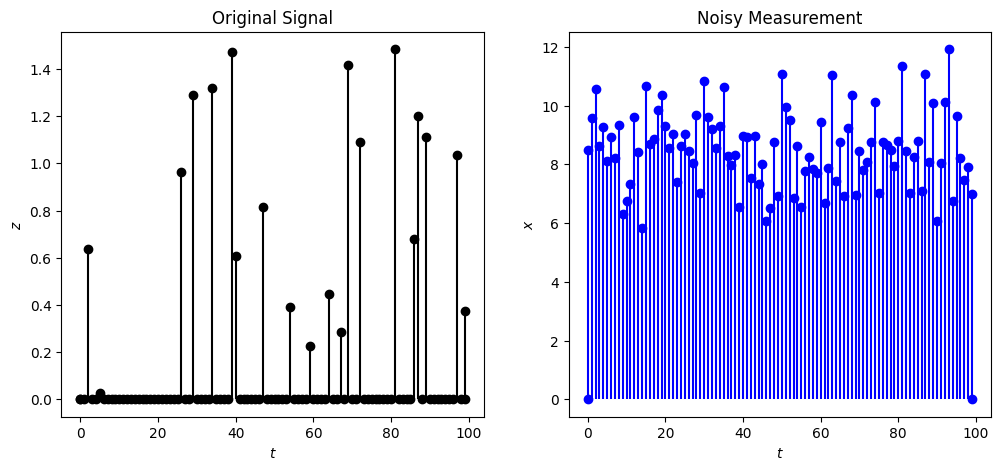

In [32]:
t = np.arange(0, 100, 1)
z = 1.5 * np.random.rand(len(t))
z = z * np.array([0 if np.random.rand() < 0.8 else 1 for i in range(len(t))])

A = np.random.rand(100, 100)

sigma = 0.05
noise = np.random.normal(0, sigma)
x = A @ z + noise


fig = plt.figure(1, dpi=100, figsize=(12, 5))
ax  = fig.subplots(nrows=1, ncols=2)
_   = ax[0].stem(t, z, "k", basefmt="ko")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, x, "b", basefmt="bo")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$x$')
_   = ax[1].set_title("Noisy Measurement")

### Task 3.1:

Implement the ISTA class for a fixed number of iterations. For the given signal, plot the total loss and sparse loss as a function of iterations. Also plot the recovered and original signals on a $2 \times 1$ grid.

In [33]:
class ISTA:
    def __init__(self, lambd: float, max_iter=1000):
        """Initialize the ISTA algorithm parameters."""
        self.lambd = lambd
        self.max_iter = max_iter
        self.loss_history_reconstruction = []
        self.loss_history_sparse = []
        self.loss_history_combined = []

    def _soft(self, z: np.ndarray, T: float) -> np.ndarray:
        """Apply soft-thresholding to the input vector."""
        return np.sign(z) * np.maximum(np.abs(z) - T, 0)

    def _run_one_iter(self, z: np.ndarray, x: np.ndarray, A: np.ndarray, alpha: float):
        """Run one iteration of the ISTA algorithm."""

        # Gradient update step
        gradient_step = z + (1 / alpha) * A.T @ (x - A @ z)

        # Apply soft-thresholding
        z_next = self._soft(gradient_step, self.lambd / (2 * alpha))

        # Compute reconstruction loss ||x - Az||^2
        reconstruction_loss = np.linalg.norm(x - A @ z_next) ** 2

        # Compute sparse loss ||z||_1
        sparse_loss = self.lambd * np.linalg.norm(z_next, 1)

        # Total loss
        total_loss = reconstruction_loss + sparse_loss

        # Store the loss values for visualization
        self.loss_history_reconstruction.append(reconstruction_loss)
        self.loss_history_sparse.append(sparse_loss)
        self.loss_history_combined.append(total_loss)

        return z_next

    def optimize(self, A: np.ndarray, x: np.ndarray, alpha: float) -> np.ndarray:
        """Optimize the solution using the ISTA algorithm."""
        m, n = A.shape
        z = np.zeros(n)  # Initialize z as a zero vector

        # Iterate for the maximum number of iterations
        for i in range(self.max_iter):
            z = self._run_one_iter(z, x, A, alpha)

        return z

    def visualize_loss_history(self):
        """Visualize the loss history over the iterations."""

        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

        ax.plot(self.loss_history_combined, label='Total Loss', color='r')
        ax.plot(self.loss_history_reconstruction, label='Reconstruction Loss', color='g')
        ax.plot(self.loss_history_sparse, label='Sparse Loss', color='b')

        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')
        ax.set_title('Loss History Over Iterations')
        ax.legend()
        plt.show()

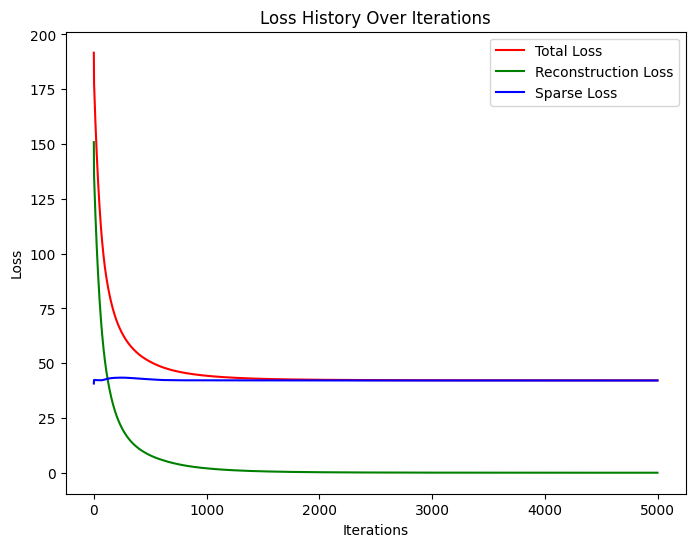

In [34]:
# Example use case with the existing variables
opt = ISTA(2.5, max_iter=5000)
eigs, _ = np.linalg.eig(A.T @ A)
alpha = max(eigs) + 100

# Optimize and recover the signal
z_recovered = opt.optimize(A, x, alpha)

# Visualize the loss history
opt.visualize_loss_history()

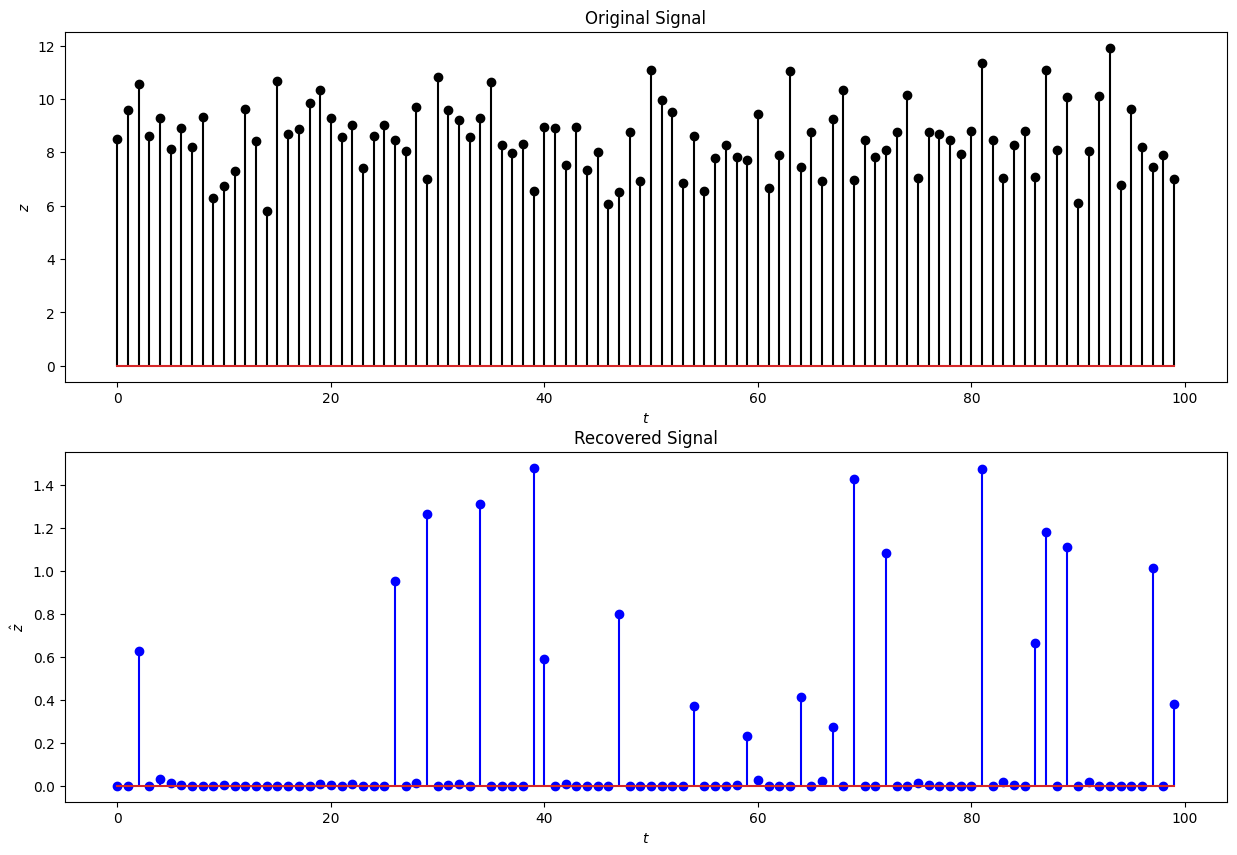

In [35]:
fig = plt.figure(dpi=100, figsize=(15, 10))
ax  = fig.subplots(2, 1)
_   = ax[0].stem(t, x, "k", label="Original Signal")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, z_recovered, "b", label="Recovered Signal")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$\hat{z}$')
_   = ax[1].set_title("Recovered Signal")

### Task 3.2

Add in your response to Task 3.2 from the manual in the cells below.

### Answer:
As the sparsity level of the underlying vector \( z \) changes, both the convergence speed of the ISTA algorithm and the accuracy of the recovered signal are impacted. When \( z \) is highly sparse, meaning it has very few non-zero elements, the algorithm converges faster. This is because the soft-thresholding operator more easily identifies and shrinks small values to zero, allowing the algorithm to quickly arrive at a sparse solution. In these cases, the loss decreases sharply in the initial iterations, and the final recovery is quite accurate, with the non-zero elements being clearly distinguished and the rest of the signal almost completely zero.

On the other hand, when the signal is less sparse, with more non-zero elements in \( z \), the convergence slows down. The algorithm has a harder time distinguishing between which values should remain and which should be shrunk to zero. As a result, the loss decreases more gradually, and the recovery of the signal becomes less precise. The recovered signal may contain some inaccuracies, with the non-zero elements being underestimated or additional noise appearing. In general, the less sparse the signal, the more challenging it is for ISTA to recover it perfectly, and the algorithm needs more iterations to produce a satisfactory result.

In summary, higher sparsity leads to faster convergence and more accurate recovery of non-zero elements, while lower sparsity makes the recovery process slower and less precise due to the increased difficulty in maintaining the correct non-zero elements in the solution.


## Section 2: Unfolding

In section 1, we had the luxury of knowing what our measurement matrix $A$ was. Yet, we had to choose values of $\alpha$ and $\lambda$ manually and a little experimentation will show you that their choice impacts the performance of the algorithm greatly. Our new problem setup assumes that we only have access to some noisy measurements $\mathbf{z}$ and our objective is to recover the underlying sparse signal $\mathbf{z}$ with no knowledge of $\mathbf{A}$.

To do so, we turn our attention towards neural networks.


The following code will help you load and create a dataset from the given `sparse_signals.pkl` file. Do not change it.

The training data comprises of 9000 input $\mathbf{z} \in \mathbb{R}^{100}$ and output $\mathbf{x} \in \mathbb{R}^{100}$ signal pairs while test set contains 1000 samples.

In [36]:
class SparseSignalsDataset(Dataset):
  def __init__(self, Z, X):
    self.z = torch.tensor(np.array(Z), dtype=torch.float32)
    self.x = torch.tensor(np.array(X), dtype=torch.float32)

  def __len__(self):
    return len(self.z)

  def __getitem__(self, idx):
    return self.z[idx], self.x[idx]

In [37]:
def load_file(filename='signals.pkl'):
    with open(filename, 'rb') as f:
        Z, X = pickle.load(f)
    return Z, X

In [38]:
# DO NOT MODIFY
filename = "/content/drive/MyDrive/sparse_signals.pkl"
Z, X = load_file(filename=filename)
dataset = SparseSignalsDataset(Z, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Task 3.3

Refer to the manual for this task.

In [39]:
def visualize(model, test_loader, num_samples, configs):
  model.eval()
  fig = plt.figure(figsize=(12, 5))
  axs = fig.subplots(2, num_samples)
  t = np.arange(0, 100, 1)
  with torch.no_grad():
    for i, (z, x) in enumerate(test_loader):
      if i == num_samples:
        break
      z, x = z.to(configs["device"]), x.to(configs["device"])
      z_hat = model(x)[0, :].cpu().numpy()
      z = z[0, :].cpu().numpy()
      _   = axs[0, i].stem(t, z, "k")
      _   = axs[0, i].set_xlabel(r'$t$')
      _   = axs[0, i].set_ylabel(r'$z$')
      _   = axs[0, i].set_title("Original Signal")

      _   = axs[1, i].stem(t, z_hat, "b")
      _   = axs[1, i].set_xlabel(r'$t$')
      _   = axs[1, i].set_ylabel(r'$\hat{z}$')
      _   = axs[1, i].set_title("Recovered Signal")
  plt.tight_layout()
  plt.show()
  return axs

In [40]:
# Ignore the use of x, y here - those are just placeholders

def train(model, train_loader, loss_fn, optimizer, configs):
  model.train()
  loss_history = []  # To store loss for each epoch
  for epoch in range(configs["epochs"]):
    running_loss = 0.0
    for x, y in train_loader:
      x, y = x.to(configs["device"]), y.to(configs["device"])
      optimizer.zero_grad()
      x_hat = model(y)
      loss = loss_fn(x_hat, x)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * y.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)  # Append the epoch loss to the history
    print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

  # Plot the training loss curve
  plt.figure(figsize=(8, 6))
  plt.plot(loss_history, label='Training Loss', color='blue')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training Loss Curve')
  plt.legend()
  plt.grid(True)
  plt.show()

def evaluate(model, test_loader, loss_fn, configs, tol=1e-6):
  model.eval()
  running_loss = 0.0
  sparsities = []
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(configs["device"]), y.to(configs["device"])
      x_hat = model(y)
      loss = loss_fn(x_hat, x)
      running_loss += loss.item() * y.size(0)
      sparsities.append(torch.sum(torch.abs(x_hat) < tol).item()/x_hat.numel())
  avg_loss = running_loss / len(test_loader.dataset)
  avg_sparsity = np.mean(sparsities)
  print(f"Test Loss: {avg_loss:.4f}")
  print(f"Average Sparsity: {avg_sparsity:.4f}")
  return avg_loss, avg_sparsity

In [41]:
class ISTABlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        """Initialize the ISTA block with a learnable threshold and a linear layer."""

        super(ISTABlock, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.threshold = nn.Parameter(torch.Tensor([0.1]))  # Learnable threshold parameter

    def _soft(self, x, T):
        """Apply soft-thresholding with threshold T."""

        return torch.sign(x) * torch.relu(torch.abs(x) - T)

    def forward(self, x):
        """Perform the forward pass through the ISTA block."""

        z = self.linear(x)  # Linear transformation
        z = self._soft(z, self.threshold)  # Apply soft-thresholding
        return z


class UnfoldedNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with multiple ISTA blocks."""

        super(UnfoldedNN, self).__init__()
        input_dim = configs["input_dim"]
        hidden_dims = configs["hidden_dims"]
        output_dim = configs["output_dim"]

        # Create the sequence of ISTA blocks
        self.ista_blocks = nn.ModuleList()
        previous_dim = input_dim

        for hidden_dim in hidden_dims:
            self.ista_blocks.append(ISTABlock(previous_dim, hidden_dim))
            previous_dim = hidden_dim

        # Output layer
        self.ista_blocks.append(ISTABlock(previous_dim, output_dim))


    def forward(self, x):
        """Perform the forward pass through the unfolded neural network."""

        for block in self.ista_blocks:
            x = block(x)  # Pass through each ISTA block
        return x

In [42]:
configs_unfolded = {
    "input_dim": 100,
    "hidden_dims": [256, 256],
    "output_dim": 100,
    "lr": 1e-4,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

Epoch: [1/30], Loss: 0.1715
Epoch: [2/30], Loss: 0.1478
Epoch: [3/30], Loss: 0.1403
Epoch: [4/30], Loss: 0.1300
Epoch: [5/30], Loss: 0.1173
Epoch: [6/30], Loss: 0.1031
Epoch: [7/30], Loss: 0.0882
Epoch: [8/30], Loss: 0.0750
Epoch: [9/30], Loss: 0.0651
Epoch: [10/30], Loss: 0.0584
Epoch: [11/30], Loss: 0.0539
Epoch: [12/30], Loss: 0.0508
Epoch: [13/30], Loss: 0.0485
Epoch: [14/30], Loss: 0.0468
Epoch: [15/30], Loss: 0.0453
Epoch: [16/30], Loss: 0.0439
Epoch: [17/30], Loss: 0.0428
Epoch: [18/30], Loss: 0.0419
Epoch: [19/30], Loss: 0.0413
Epoch: [20/30], Loss: 0.0407
Epoch: [21/30], Loss: 0.0402
Epoch: [22/30], Loss: 0.0398
Epoch: [23/30], Loss: 0.0395
Epoch: [24/30], Loss: 0.0391
Epoch: [25/30], Loss: 0.0389
Epoch: [26/30], Loss: 0.0386
Epoch: [27/30], Loss: 0.0384
Epoch: [28/30], Loss: 0.0382
Epoch: [29/30], Loss: 0.0381
Epoch: [30/30], Loss: 0.0379


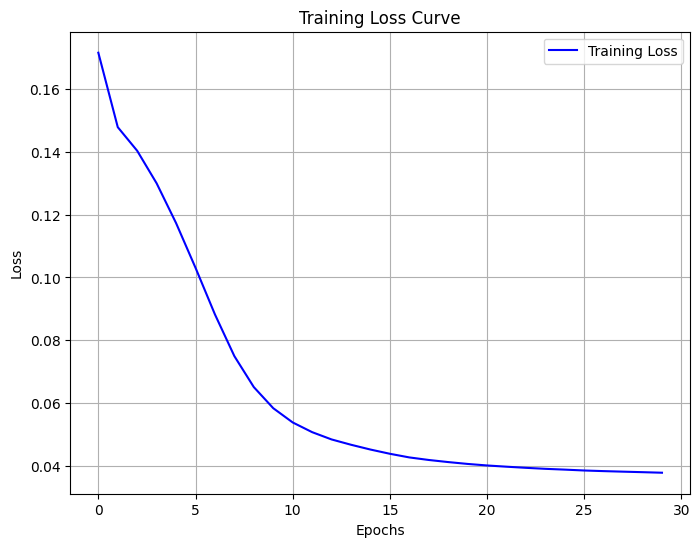

In [43]:
# Create the model
model_unfolded = UnfoldedNN(configs_unfolded).to(configs_unfolded["device"])

# Define optimizer and loss function
optimizer = torch.optim.Adam(model_unfolded.parameters(), lr=configs_unfolded["lr"])
L1 = nn.L1Loss()

# Train the unfolded neural network
train(model=model_unfolded, train_loader=train_loader, loss_fn=L1, optimizer=optimizer, configs=configs_unfolded)

Test Loss: 0.0390
Average Sparsity: 0.7608


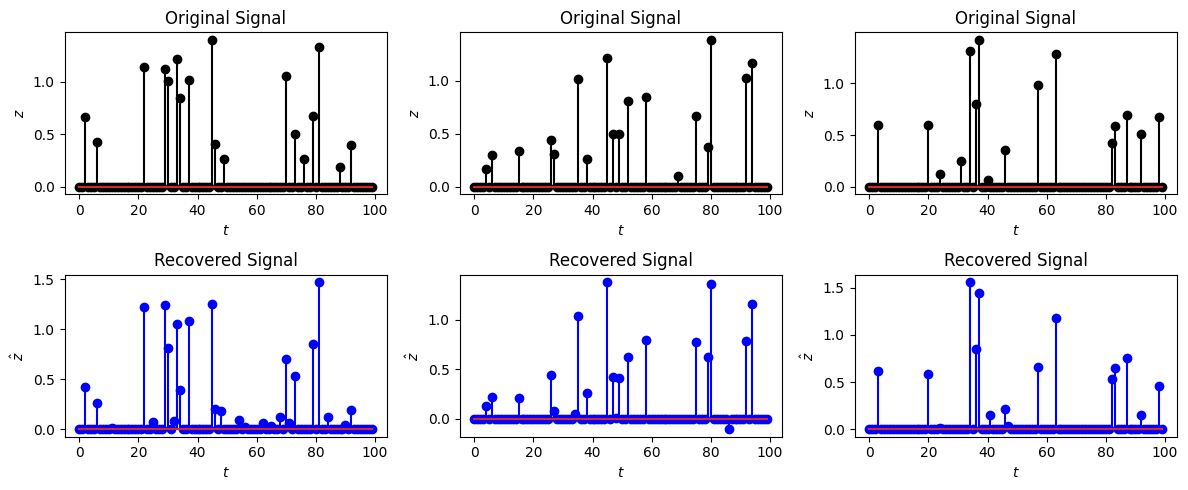

Total number of trainable parameters: 117351


In [44]:
# Evaluate the model
avg_eval_loss_unfolded, avg_eval_sparsity_unfolded = evaluate(model_unfolded, test_loader, L1, configs_unfolded)

# Visualize the results for some test samples
_ = visualize(model_unfolded, test_loader, 3, configs_unfolded)

In [ ]:
total_params = sum(p.numel() for p in model_unfolded.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

# Experimenting with Depth , Optimizers and Learning Rates

We will experiment with:

- Depth: Vary the number of hidden layers in the UnfoldedNN (e.g., [256, 256], [512, 512], etc.).
- Optimizers: Use different optimizers (e.g., Adam, SGD).
- Learning Rates: Try different learning rates (e.g., 1e-3, 1e-4).

Running experiment with depth: [256, 256], optimizer: Adam, learning rate: 0.0001
Epoch: [1/30], Loss: 0.1722
Epoch: [2/30], Loss: 0.1473
Epoch: [3/30], Loss: 0.1395
Epoch: [4/30], Loss: 0.1294
Epoch: [5/30], Loss: 0.1174
Epoch: [6/30], Loss: 0.1039
Epoch: [7/30], Loss: 0.0901
Epoch: [8/30], Loss: 0.0779
Epoch: [9/30], Loss: 0.0685
Epoch: [10/30], Loss: 0.0619
Epoch: [11/30], Loss: 0.0573
Epoch: [12/30], Loss: 0.0540
Epoch: [13/30], Loss: 0.0516
Epoch: [14/30], Loss: 0.0497
Epoch: [15/30], Loss: 0.0482
Epoch: [16/30], Loss: 0.0470
Epoch: [17/30], Loss: 0.0457
Epoch: [18/30], Loss: 0.0446
Epoch: [19/30], Loss: 0.0438
Epoch: [20/30], Loss: 0.0432
Epoch: [21/30], Loss: 0.0427
Epoch: [22/30], Loss: 0.0423
Epoch: [23/30], Loss: 0.0419
Epoch: [24/30], Loss: 0.0415
Epoch: [25/30], Loss: 0.0413
Epoch: [26/30], Loss: 0.0410
Epoch: [27/30], Loss: 0.0408
Epoch: [28/30], Loss: 0.0406
Epoch: [29/30], Loss: 0.0404
Epoch: [30/30], Loss: 0.0401


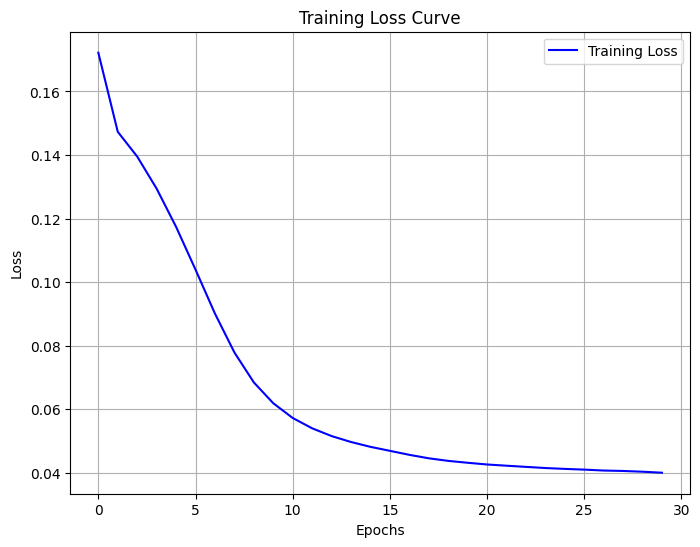

Test Loss: 0.0409
Average Sparsity: 0.7701
Running experiment with depth: [256, 256], optimizer: SGD, learning rate: 0.0001
Epoch: [1/30], Loss: 0.2617
Epoch: [2/30], Loss: 0.1878
Epoch: [3/30], Loss: 0.1695
Epoch: [4/30], Loss: 0.1623
Epoch: [5/30], Loss: 0.1586
Epoch: [6/30], Loss: 0.1565
Epoch: [7/30], Loss: 0.1551
Epoch: [8/30], Loss: 0.1541
Epoch: [9/30], Loss: 0.1534
Epoch: [10/30], Loss: 0.1529
Epoch: [11/30], Loss: 0.1525
Epoch: [12/30], Loss: 0.1522
Epoch: [13/30], Loss: 0.1519
Epoch: [14/30], Loss: 0.1517
Epoch: [15/30], Loss: 0.1516
Epoch: [16/30], Loss: 0.1514
Epoch: [17/30], Loss: 0.1513
Epoch: [18/30], Loss: 0.1512
Epoch: [19/30], Loss: 0.1511
Epoch: [20/30], Loss: 0.1510
Epoch: [21/30], Loss: 0.1509
Epoch: [22/30], Loss: 0.1508
Epoch: [23/30], Loss: 0.1508
Epoch: [24/30], Loss: 0.1507
Epoch: [25/30], Loss: 0.1507
Epoch: [26/30], Loss: 0.1506
Epoch: [27/30], Loss: 0.1506
Epoch: [28/30], Loss: 0.1506
Epoch: [29/30], Loss: 0.1505
Epoch: [30/30], Loss: 0.1505


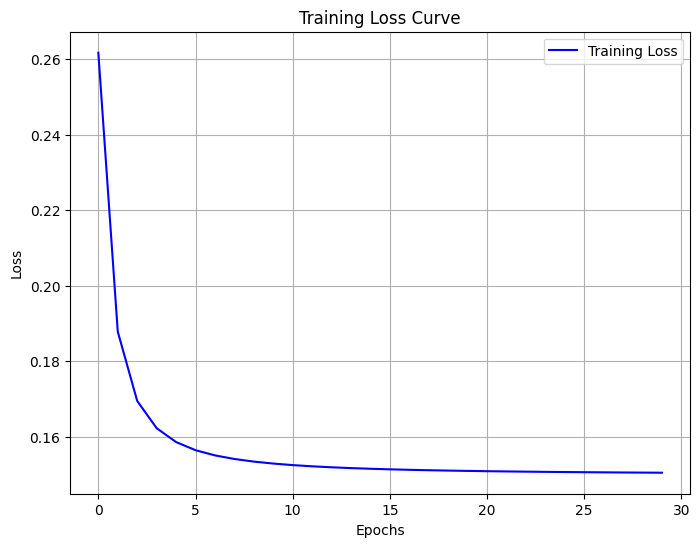

Test Loss: 0.1505
Average Sparsity: 0.9886
Running experiment with depth: [256, 256], optimizer: Adam, learning rate: 0.001
Epoch: [1/30], Loss: 0.1354
Epoch: [2/30], Loss: 0.0685
Epoch: [3/30], Loss: 0.0535
Epoch: [4/30], Loss: 0.0511
Epoch: [5/30], Loss: 0.0498
Epoch: [6/30], Loss: 0.0493
Epoch: [7/30], Loss: 0.0491
Epoch: [8/30], Loss: 0.0489
Epoch: [9/30], Loss: 0.0486
Epoch: [10/30], Loss: 0.0485
Epoch: [11/30], Loss: 0.0486
Epoch: [12/30], Loss: 0.0487
Epoch: [13/30], Loss: 0.0486
Epoch: [14/30], Loss: 0.0486
Epoch: [15/30], Loss: 0.0488
Epoch: [16/30], Loss: 0.0486
Epoch: [17/30], Loss: 0.0485
Epoch: [18/30], Loss: 0.0486
Epoch: [19/30], Loss: 0.0485
Epoch: [20/30], Loss: 0.0487
Epoch: [21/30], Loss: 0.0487
Epoch: [22/30], Loss: 0.0486
Epoch: [23/30], Loss: 0.0485
Epoch: [24/30], Loss: 0.0484
Epoch: [25/30], Loss: 0.0485
Epoch: [26/30], Loss: 0.0488
Epoch: [27/30], Loss: 0.0486
Epoch: [28/30], Loss: 0.0483
Epoch: [29/30], Loss: 0.0485
Epoch: [30/30], Loss: 0.0482


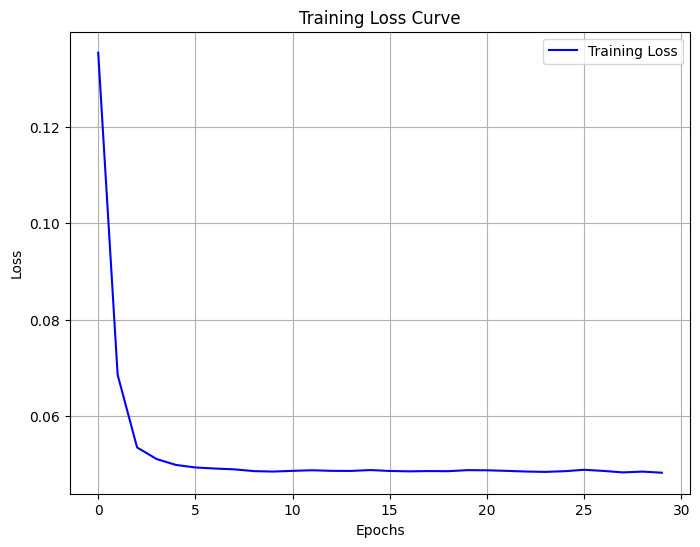

Test Loss: 0.0489
Average Sparsity: 0.7887
Running experiment with depth: [256, 256], optimizer: SGD, learning rate: 0.001
Epoch: [1/30], Loss: 0.1714
Epoch: [2/30], Loss: 0.1513
Epoch: [3/30], Loss: 0.1506
Epoch: [4/30], Loss: 0.1503
Epoch: [5/30], Loss: 0.1502
Epoch: [6/30], Loss: 0.1501
Epoch: [7/30], Loss: 0.1501
Epoch: [8/30], Loss: 0.1500
Epoch: [9/30], Loss: 0.1500
Epoch: [10/30], Loss: 0.1500
Epoch: [11/30], Loss: 0.1500
Epoch: [12/30], Loss: 0.1500
Epoch: [13/30], Loss: 0.1499
Epoch: [14/30], Loss: 0.1499
Epoch: [15/30], Loss: 0.1499
Epoch: [16/30], Loss: 0.1499
Epoch: [17/30], Loss: 0.1499
Epoch: [18/30], Loss: 0.1499
Epoch: [19/30], Loss: 0.1499
Epoch: [20/30], Loss: 0.1499
Epoch: [21/30], Loss: 0.1499
Epoch: [22/30], Loss: 0.1499
Epoch: [23/30], Loss: 0.1499
Epoch: [24/30], Loss: 0.1499
Epoch: [25/30], Loss: 0.1499
Epoch: [26/30], Loss: 0.1499
Epoch: [27/30], Loss: 0.1499
Epoch: [28/30], Loss: 0.1499
Epoch: [29/30], Loss: 0.1499
Epoch: [30/30], Loss: 0.1499


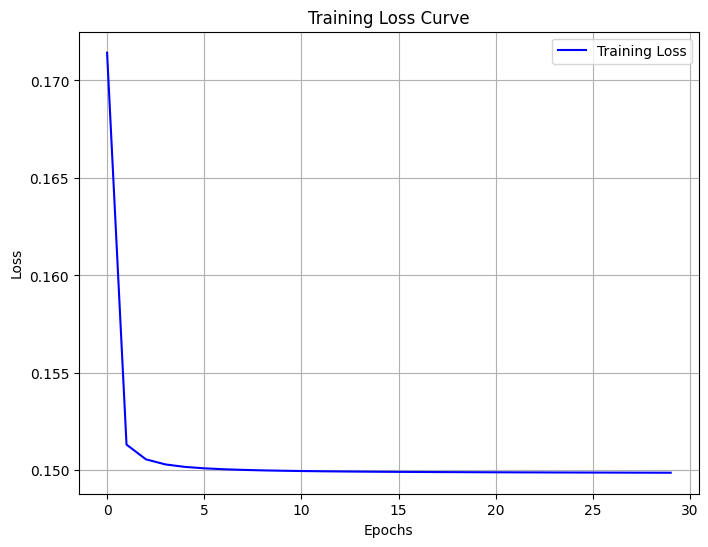

Test Loss: 0.1499
Average Sparsity: 0.9981
Running experiment with depth: [512, 512], optimizer: Adam, learning rate: 0.0001
Epoch: [1/30], Loss: 0.1599
Epoch: [2/30], Loss: 0.1312
Epoch: [3/30], Loss: 0.1088
Epoch: [4/30], Loss: 0.0869
Epoch: [5/30], Loss: 0.0700
Epoch: [6/30], Loss: 0.0595
Epoch: [7/30], Loss: 0.0531
Epoch: [8/30], Loss: 0.0492
Epoch: [9/30], Loss: 0.0467
Epoch: [10/30], Loss: 0.0448
Epoch: [11/30], Loss: 0.0435
Epoch: [12/30], Loss: 0.0425
Epoch: [13/30], Loss: 0.0417
Epoch: [14/30], Loss: 0.0411
Epoch: [15/30], Loss: 0.0406
Epoch: [16/30], Loss: 0.0401
Epoch: [17/30], Loss: 0.0398
Epoch: [18/30], Loss: 0.0395
Epoch: [19/30], Loss: 0.0393
Epoch: [20/30], Loss: 0.0390
Epoch: [21/30], Loss: 0.0388
Epoch: [22/30], Loss: 0.0387
Epoch: [23/30], Loss: 0.0385
Epoch: [24/30], Loss: 0.0384
Epoch: [25/30], Loss: 0.0383
Epoch: [26/30], Loss: 0.0382
Epoch: [27/30], Loss: 0.0381
Epoch: [28/30], Loss: 0.0381
Epoch: [29/30], Loss: 0.0380
Epoch: [30/30], Loss: 0.0380


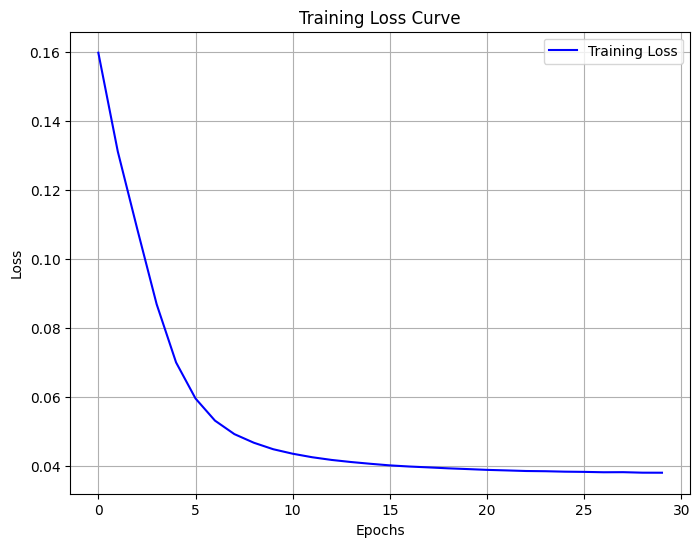

Test Loss: 0.0391
Average Sparsity: 0.7712
Running experiment with depth: [512, 512], optimizer: SGD, learning rate: 0.0001
Epoch: [1/30], Loss: 0.2434
Epoch: [2/30], Loss: 0.1800
Epoch: [3/30], Loss: 0.1660
Epoch: [4/30], Loss: 0.1602
Epoch: [5/30], Loss: 0.1573
Epoch: [6/30], Loss: 0.1555
Epoch: [7/30], Loss: 0.1543
Epoch: [8/30], Loss: 0.1535
Epoch: [9/30], Loss: 0.1529
Epoch: [10/30], Loss: 0.1524
Epoch: [11/30], Loss: 0.1521
Epoch: [12/30], Loss: 0.1518
Epoch: [13/30], Loss: 0.1516
Epoch: [14/30], Loss: 0.1514
Epoch: [15/30], Loss: 0.1512
Epoch: [16/30], Loss: 0.1511
Epoch: [17/30], Loss: 0.1510
Epoch: [18/30], Loss: 0.1509
Epoch: [19/30], Loss: 0.1508
Epoch: [20/30], Loss: 0.1508
Epoch: [21/30], Loss: 0.1507
Epoch: [22/30], Loss: 0.1506
Epoch: [23/30], Loss: 0.1506
Epoch: [24/30], Loss: 0.1505
Epoch: [25/30], Loss: 0.1505
Epoch: [26/30], Loss: 0.1505
Epoch: [27/30], Loss: 0.1504
Epoch: [28/30], Loss: 0.1504
Epoch: [29/30], Loss: 0.1504
Epoch: [30/30], Loss: 0.1504


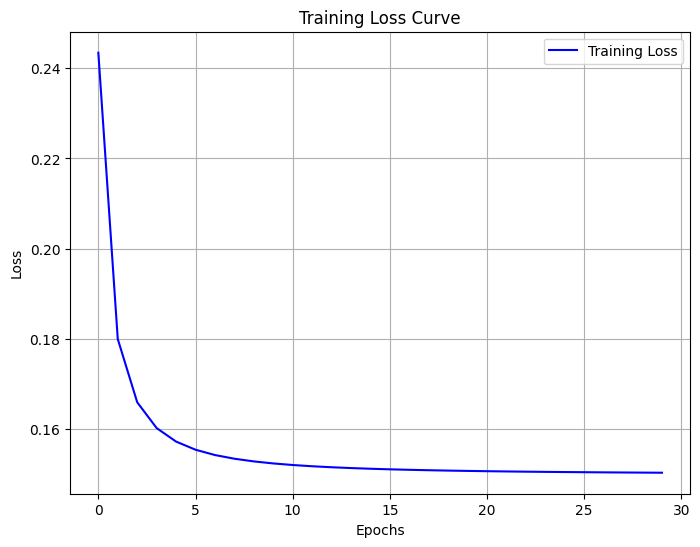

Test Loss: 0.1504
Average Sparsity: 0.9882
Running experiment with depth: [512, 512], optimizer: Adam, learning rate: 0.001
Epoch: [1/30], Loss: 0.1167
Epoch: [2/30], Loss: 0.0611
Epoch: [3/30], Loss: 0.0539
Epoch: [4/30], Loss: 0.0520
Epoch: [5/30], Loss: 0.0513
Epoch: [6/30], Loss: 0.0516
Epoch: [7/30], Loss: 0.0514
Epoch: [8/30], Loss: 0.0518
Epoch: [9/30], Loss: 0.0518
Epoch: [10/30], Loss: 0.0520
Epoch: [11/30], Loss: 0.0524
Epoch: [12/30], Loss: 0.0523
Epoch: [13/30], Loss: 0.0524
Epoch: [14/30], Loss: 0.0524
Epoch: [15/30], Loss: 0.0526
Epoch: [16/30], Loss: 0.0526
Epoch: [17/30], Loss: 0.0524
Epoch: [18/30], Loss: 0.0524
Epoch: [19/30], Loss: 0.0521
Epoch: [20/30], Loss: 0.0523
Epoch: [21/30], Loss: 0.0520
Epoch: [22/30], Loss: 0.0519
Epoch: [23/30], Loss: 0.0514
Epoch: [24/30], Loss: 0.0511
Epoch: [25/30], Loss: 0.0510
Epoch: [26/30], Loss: 0.0504
Epoch: [27/30], Loss: 0.0504
Epoch: [28/30], Loss: 0.0504
Epoch: [29/30], Loss: 0.0503
Epoch: [30/30], Loss: 0.0499


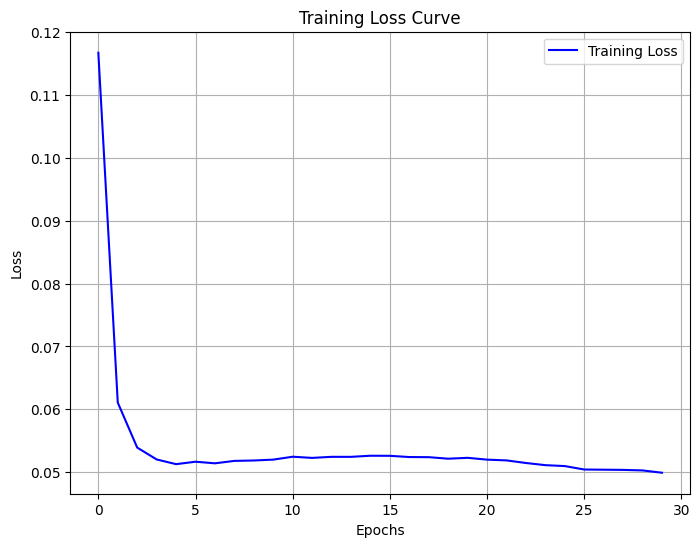

Test Loss: 0.0527
Average Sparsity: 0.7867
Running experiment with depth: [512, 512], optimizer: SGD, learning rate: 0.001
Epoch: [1/30], Loss: 0.1715
Epoch: [2/30], Loss: 0.1512
Epoch: [3/30], Loss: 0.1505
Epoch: [4/30], Loss: 0.1502
Epoch: [5/30], Loss: 0.1501
Epoch: [6/30], Loss: 0.1501
Epoch: [7/30], Loss: 0.1500
Epoch: [8/30], Loss: 0.1500
Epoch: [9/30], Loss: 0.1500
Epoch: [10/30], Loss: 0.1499
Epoch: [11/30], Loss: 0.1499
Epoch: [12/30], Loss: 0.1499
Epoch: [13/30], Loss: 0.1499
Epoch: [14/30], Loss: 0.1499
Epoch: [15/30], Loss: 0.1499
Epoch: [16/30], Loss: 0.1499
Epoch: [17/30], Loss: 0.1499
Epoch: [18/30], Loss: 0.1499
Epoch: [19/30], Loss: 0.1499
Epoch: [20/30], Loss: 0.1499
Epoch: [21/30], Loss: 0.1498
Epoch: [22/30], Loss: 0.1498
Epoch: [23/30], Loss: 0.1498
Epoch: [24/30], Loss: 0.1498
Epoch: [25/30], Loss: 0.1498
Epoch: [26/30], Loss: 0.1498
Epoch: [27/30], Loss: 0.1498
Epoch: [28/30], Loss: 0.1498
Epoch: [29/30], Loss: 0.1498
Epoch: [30/30], Loss: 0.1498


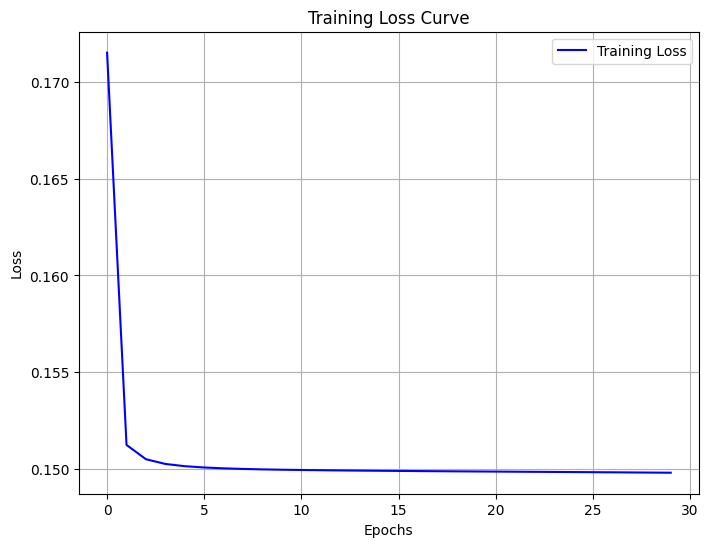

Test Loss: 0.1499
Average Sparsity: 0.9961
Running experiment with depth: [256, 512], optimizer: Adam, learning rate: 0.0001
Epoch: [1/30], Loss: 0.1655
Epoch: [2/30], Loss: 0.1408
Epoch: [3/30], Loss: 0.1263
Epoch: [4/30], Loss: 0.1100
Epoch: [5/30], Loss: 0.0931
Epoch: [6/30], Loss: 0.0777
Epoch: [7/30], Loss: 0.0666
Epoch: [8/30], Loss: 0.0592
Epoch: [9/30], Loss: 0.0547
Epoch: [10/30], Loss: 0.0513
Epoch: [11/30], Loss: 0.0490
Epoch: [12/30], Loss: 0.0472
Epoch: [13/30], Loss: 0.0458
Epoch: [14/30], Loss: 0.0448
Epoch: [15/30], Loss: 0.0439
Epoch: [16/30], Loss: 0.0432
Epoch: [17/30], Loss: 0.0426
Epoch: [18/30], Loss: 0.0422
Epoch: [19/30], Loss: 0.0418
Epoch: [20/30], Loss: 0.0414
Epoch: [21/30], Loss: 0.0411
Epoch: [22/30], Loss: 0.0409
Epoch: [23/30], Loss: 0.0407
Epoch: [24/30], Loss: 0.0405
Epoch: [25/30], Loss: 0.0404
Epoch: [26/30], Loss: 0.0403
Epoch: [27/30], Loss: 0.0402
Epoch: [28/30], Loss: 0.0400
Epoch: [29/30], Loss: 0.0399
Epoch: [30/30], Loss: 0.0398


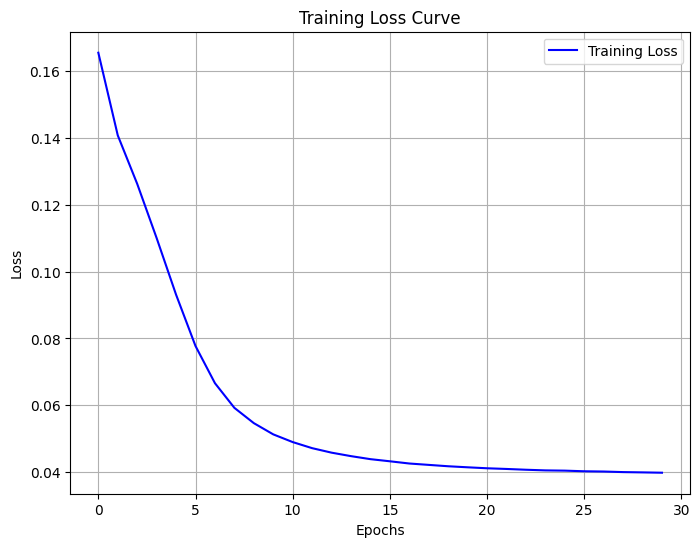

Test Loss: 0.0413
Average Sparsity: 0.7631
Running experiment with depth: [256, 512], optimizer: SGD, learning rate: 0.0001
Epoch: [1/30], Loss: 0.2509
Epoch: [2/30], Loss: 0.1844
Epoch: [3/30], Loss: 0.1679
Epoch: [4/30], Loss: 0.1613
Epoch: [5/30], Loss: 0.1580
Epoch: [6/30], Loss: 0.1560
Epoch: [7/30], Loss: 0.1547
Epoch: [8/30], Loss: 0.1538
Epoch: [9/30], Loss: 0.1532
Epoch: [10/30], Loss: 0.1527
Epoch: [11/30], Loss: 0.1523
Epoch: [12/30], Loss: 0.1520
Epoch: [13/30], Loss: 0.1518
Epoch: [14/30], Loss: 0.1516
Epoch: [15/30], Loss: 0.1514
Epoch: [16/30], Loss: 0.1513
Epoch: [17/30], Loss: 0.1511
Epoch: [18/30], Loss: 0.1510
Epoch: [19/30], Loss: 0.1509
Epoch: [20/30], Loss: 0.1509
Epoch: [21/30], Loss: 0.1508
Epoch: [22/30], Loss: 0.1507
Epoch: [23/30], Loss: 0.1507
Epoch: [24/30], Loss: 0.1506
Epoch: [25/30], Loss: 0.1506
Epoch: [26/30], Loss: 0.1505
Epoch: [27/30], Loss: 0.1505
Epoch: [28/30], Loss: 0.1505
Epoch: [29/30], Loss: 0.1504
Epoch: [30/30], Loss: 0.1504


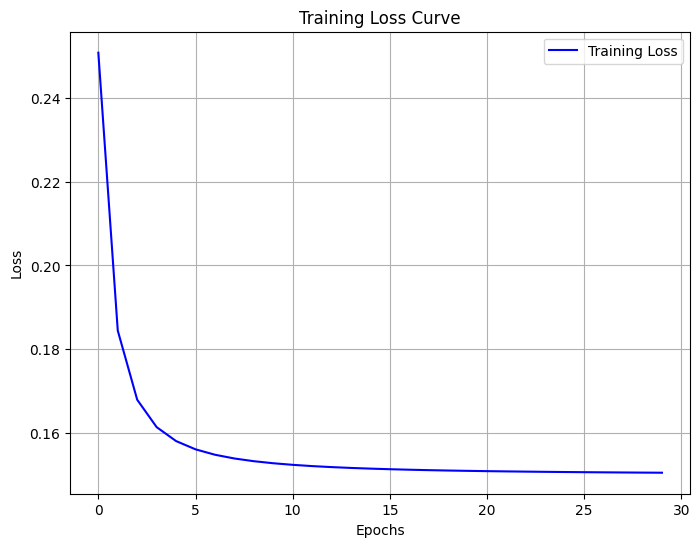

Test Loss: 0.1505
Average Sparsity: 0.9885
Running experiment with depth: [512, 512, 512], optimizer: Adam, learning rate: 0.0001
Epoch: [1/30], Loss: 0.1507
Epoch: [2/30], Loss: 0.1385
Epoch: [3/30], Loss: 0.1126
Epoch: [4/30], Loss: 0.0856
Epoch: [5/30], Loss: 0.0668
Epoch: [6/30], Loss: 0.0564
Epoch: [7/30], Loss: 0.0513
Epoch: [8/30], Loss: 0.0483
Epoch: [9/30], Loss: 0.0463
Epoch: [10/30], Loss: 0.0447
Epoch: [11/30], Loss: 0.0433
Epoch: [12/30], Loss: 0.0424
Epoch: [13/30], Loss: 0.0419
Epoch: [14/30], Loss: 0.0413
Epoch: [15/30], Loss: 0.0407
Epoch: [16/30], Loss: 0.0401
Epoch: [17/30], Loss: 0.0397
Epoch: [18/30], Loss: 0.0395
Epoch: [19/30], Loss: 0.0392
Epoch: [20/30], Loss: 0.0391
Epoch: [21/30], Loss: 0.0390
Epoch: [22/30], Loss: 0.0389
Epoch: [23/30], Loss: 0.0388
Epoch: [24/30], Loss: 0.0387
Epoch: [25/30], Loss: 0.0386
Epoch: [26/30], Loss: 0.0385
Epoch: [27/30], Loss: 0.0384
Epoch: [28/30], Loss: 0.0384
Epoch: [29/30], Loss: 0.0384
Epoch: [30/30], Loss: 0.0384


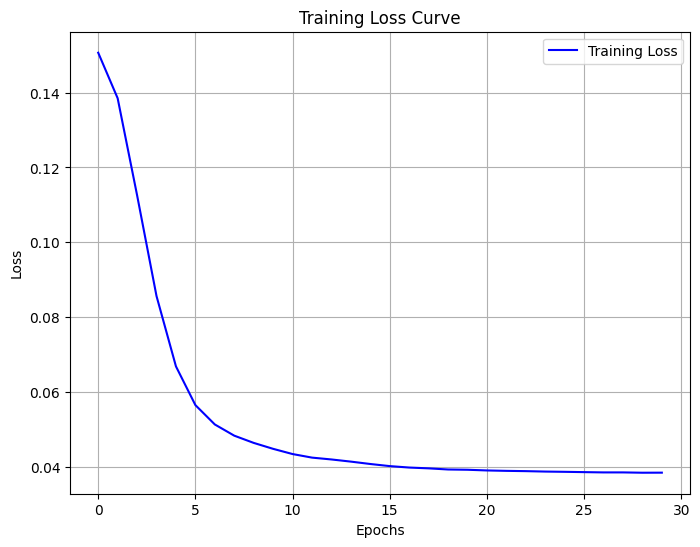

Test Loss: 0.0391
Average Sparsity: 0.7748
Running experiment with depth: [512, 512, 512], optimizer: SGD, learning rate: 0.0001
Epoch: [1/30], Loss: 0.1740
Epoch: [2/30], Loss: 0.1566
Epoch: [3/30], Loss: 0.1534
Epoch: [4/30], Loss: 0.1522
Epoch: [5/30], Loss: 0.1516
Epoch: [6/30], Loss: 0.1512
Epoch: [7/30], Loss: 0.1509
Epoch: [8/30], Loss: 0.1508
Epoch: [9/30], Loss: 0.1506
Epoch: [10/30], Loss: 0.1505
Epoch: [11/30], Loss: 0.1505
Epoch: [12/30], Loss: 0.1504
Epoch: [13/30], Loss: 0.1503
Epoch: [14/30], Loss: 0.1503
Epoch: [15/30], Loss: 0.1503
Epoch: [16/30], Loss: 0.1502
Epoch: [17/30], Loss: 0.1502
Epoch: [18/30], Loss: 0.1502
Epoch: [19/30], Loss: 0.1502
Epoch: [20/30], Loss: 0.1501
Epoch: [21/30], Loss: 0.1501
Epoch: [22/30], Loss: 0.1501
Epoch: [23/30], Loss: 0.1501
Epoch: [24/30], Loss: 0.1501
Epoch: [25/30], Loss: 0.1501
Epoch: [26/30], Loss: 0.1501
Epoch: [27/30], Loss: 0.1501
Epoch: [28/30], Loss: 0.1500
Epoch: [29/30], Loss: 0.1500
Epoch: [30/30], Loss: 0.1500


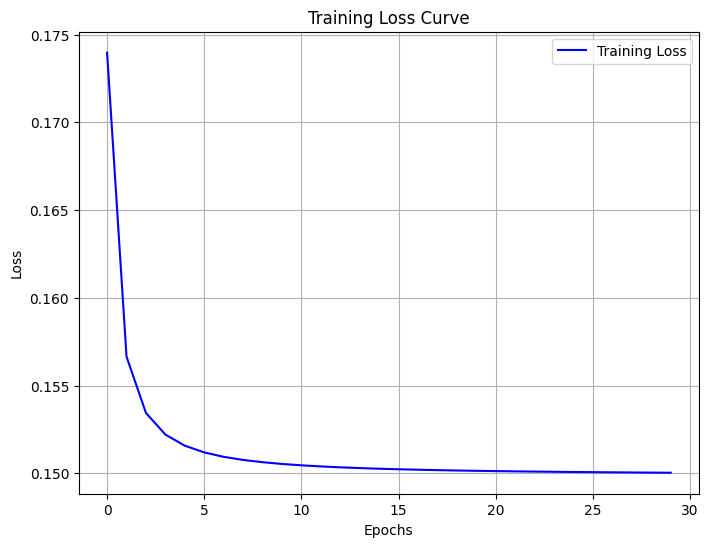

Test Loss: 0.1501
Average Sparsity: 0.9943
╒═════════════════╤═════════════╤═════════════════╤═════════════════════╤════════════════════╕
│ Depth           │ Optimizer   │   Learning Rate │   Average Test Loss │   Average Sparsity │
╞═════════════════╪═════════════╪═════════════════╪═════════════════════╪════════════════════╡
│ [256, 256]      │ Adam        │          0.0001 │           0.0409084 │           0.770099 │
├─────────────────┼─────────────┼─────────────────┼─────────────────────┼────────────────────┤
│ [256, 256]      │ SGD         │          0.0001 │           0.150535  │           0.988616 │
├─────────────────┼─────────────┼─────────────────┼─────────────────────┼────────────────────┤
│ [256, 256]      │ Adam        │          0.001  │           0.0488959 │           0.78871  │
├─────────────────┼─────────────┼─────────────────┼─────────────────────┼────────────────────┤
│ [256, 256]      │ SGD         │          0.001  │           0.149944  │           0.99811  │
├──────

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from tabulate import tabulate

# Experiment configurations: all combinations of depth, optimizer, and learning rate
experiment_configs = [
    {"depth": [256, 256], "optimizer": "Adam", "lr": 1e-4},
    {"depth": [256, 256], "optimizer": "SGD", "lr": 1e-4},
    {"depth": [256, 256], "optimizer": "Adam", "lr": 1e-3},
    {"depth": [256, 256], "optimizer": "SGD", "lr": 1e-3},
    {"depth": [512, 512], "optimizer": "Adam", "lr": 1e-4},
    {"depth": [512, 512], "optimizer": "SGD", "lr": 1e-4},
    {"depth": [512, 512], "optimizer": "Adam", "lr": 1e-3},
    {"depth": [512, 512], "optimizer": "SGD", "lr": 1e-3},
    {"depth": [256, 512], "optimizer": "Adam", "lr": 1e-4},
    {"depth": [256, 512], "optimizer": "SGD", "lr": 1e-4},
    {"depth": [512, 512, 512], "optimizer": "Adam", "lr": 1e-4},
    {"depth": [512, 512, 512], "optimizer": "SGD", "lr": 1e-4}
]

# Initialize a table to store results
results_table = []

# Function to train the model and track results
def train_and_evaluate(config):
    # Model configuration
    configs_unfolded = {
        "input_dim": 100,
        "hidden_dims": config["depth"],  # Varying depth
        "output_dim": 100,
        "lr": config["lr"],
        "epochs": 30,
        "batch_size": 32,
        "device": "cuda" if torch.cuda.is_available() else "cpu"
    }

    # Create the model
    model_unfolded = UnfoldedNN(configs_unfolded).to(configs_unfolded["device"])

    # Select optimizer
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(model_unfolded.parameters(), lr=configs_unfolded["lr"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(model_unfolded.parameters(), lr=configs_unfolded["lr"], momentum=0.9)

    # Loss function
    L1 = nn.L1Loss()

    # Train the model
    train(model=model_unfolded, train_loader=train_loader, loss_fn=L1, optimizer=optimizer, configs=configs_unfolded)

    # Evaluate the model
    avg_eval_loss, avg_eval_sparsity = evaluate(model_unfolded, test_loader, L1, configs_unfolded)

    # Store the results
    return avg_eval_loss, avg_eval_sparsity

# Run all experiments
for config in experiment_configs:
    print(f"Running experiment with depth: {config['depth']}, optimizer: {config['optimizer']}, learning rate: {config['lr']}")
    avg_loss, avg_sparsity = train_and_evaluate(config)
    results_table.append([config["depth"], config["optimizer"], config["lr"], avg_loss, avg_sparsity])

# Define the headers for the table
headers = ["Depth", "Optimizer", "Learning Rate", "Average Test Loss", "Average Sparsity"]

# Print the table using tabulate
print(tabulate(results_table, headers=headers, tablefmt="fancy_grid"))


### Task 3.4

Add in your solution to Task 3.4 from the manual in the cells below.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

import numpy as np

def ista(A, x, lambd, max_iter):
    """
    Perform ISTA with normalization and eigenvalue-based step size alpha.

    Args:
        A (np.ndarray): The measurement matrix.
        x (np.ndarray): The input noisy signal.
        lambd (float): The regularization parameter for sparsity.
        max_iter (int): Maximum number of iterations.

    Returns:
        z (np.ndarray): The recovered sparse signal.
        loss_history_combined (list): Combined loss history across iterations.
        loss_history_reconstruction (list): Reconstruction loss history.
        loss_history_sparse (list): Sparse loss history.
    """
    # Normalize A and x to prevent numerical overflow
    A_norm = np.linalg.norm(A, ord='fro')
    x_norm = np.linalg.norm(x)

    if A_norm > 0:
        A = A / A_norm  # Normalize matrix A using Frobenius norm
    if x_norm > 0:
        x = x / x_norm  # Normalize vector x

    # Calculate alpha based on the largest eigenvalue of A.T @ A
    eigs, _ = np.linalg.eig(A.T @ A)
    alpha = max(eigs) + 100  # Adjust the 100 as needed for stability

    # Initialize variables
    m, n = A.shape
    z = np.zeros(n)  # Initialize z as a zero vector
    loss_history_reconstruction = []
    loss_history_sparse = []
    loss_history_combined = []

    # Soft-thresholding function
    def soft_thresholding(z, T):
        return np.sign(z) * np.maximum(np.abs(z) - T, 0)

    # ISTA Iterative process
    for i in range(max_iter):
        # Gradient update step
        gradient_step = z + (1 / alpha) * A.T @ (x - A @ z)

        # Apply soft-thresholding
        z = soft_thresholding(gradient_step, lambd / (2 * alpha))

        # Check for NaN values in z and break if found
        if np.isnan(z).any():
            print(f"NaN detected in z at iteration {i}. Exiting iteration.")
            break

        # Compute reconstruction loss ||x - Az||^2
        reconstruction_loss = np.linalg.norm(x - A @ z) ** 2

        # Compute sparse loss ||z||_1
        sparse_loss = lambd * np.linalg.norm(z, 1)

        # Total loss
        total_loss = reconstruction_loss + sparse_loss

        # Check for NaN values in losses
        if np.isnan(total_loss):
            print(f"NaN detected in total_loss at iteration {i}. Exiting iteration.")
            break

        # Store the loss values for visualization
        loss_history_reconstruction.append(reconstruction_loss)
        loss_history_sparse.append(sparse_loss)
        loss_history_combined.append(total_loss)

    return z, loss_history_combined, loss_history_reconstruction, loss_history_sparse

# Function to train LISTA
def train(model, train_loader, loss_fn, optimizer, configs):
    model.train()
    loss_history = []  # To store loss for each epoch
    for epoch in range(configs["epochs"]):
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(configs["device"]), y.to(configs["device"])
            optimizer.zero_grad()
            x_hat = model(y)
            loss = loss_fn(x_hat, x)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * y.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        loss_history.append(epoch_loss)  # Append the epoch loss to the history
        print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

    # Return the loss history so it can be used for comparison
    return loss_history

# Function to generate sparse signals with controlled sparsity level
def generate_sparse_signals(size, sparsity_level):
    z = np.random.randn(size)
    mask = np.random.rand(size) < sparsity_level  # Create mask for sparsity
    z = z * mask  # Apply the mask to enforce sparsity
    return z

# Sparsity levels to test
sparsity_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
signal_size = 100
max_iter = 1000
lambd = 0.1
# alpha = 1.0

# Initialize results table to store the comparison between ISTA and LISTA
results_table = []

# Loop over each sparsity level
for sparsity_level in sparsity_levels:
    print(f"Running comparison for sparsity level: {sparsity_level}")

    # Generate sparse signal
    A = np.random.randn(signal_size, signal_size)  # Random measurement matrix
    z_true = generate_sparse_signals(signal_size, sparsity_level)
    noise = np.random.randn(signal_size) * 0.05
    x = A @ z_true + noise  # Noisy measurement

    # Run ISTA
    z_ista, loss_combined_ista, loss_reconstruction_ista, loss_sparse_ista = ista(A, x, lambd, max_iter)
    avg_loss_ista = np.mean(loss_combined_ista)  # Calculate average loss for ISTA

    # Run LISTA
    lista_loss_history = train(model_unfolded, train_loader, L1, optimizer, configs_unfolded)
    avg_loss_lista = np.mean(lista_loss_history)  # Calculate average loss for LISTA

    # Append results to the table
    results_table.append({
        "Sparsity Level": sparsity_level,
        "ISTA Avg Loss": avg_loss_ista,
        "LISTA Avg Loss": avg_loss_lista
    })

# Convert the results to a pandas DataFrame for easy display
df_results = pd.DataFrame(results_table)

# Print the results as a formatted table using tabulate
print(tabulate(df_results, headers="keys", tablefmt="fancy_grid"))


Running comparison for sparsity level: 0.1
Epoch: [1/30], Loss: 0.0348
Epoch: [2/30], Loss: 0.0348
Epoch: [3/30], Loss: 0.0348
Epoch: [4/30], Loss: 0.0348
Epoch: [5/30], Loss: 0.0348
Epoch: [6/30], Loss: 0.0348
Epoch: [7/30], Loss: 0.0348
Epoch: [8/30], Loss: 0.0348
Epoch: [9/30], Loss: 0.0348
Epoch: [10/30], Loss: 0.0348
Epoch: [11/30], Loss: 0.0348
Epoch: [12/30], Loss: 0.0348
Epoch: [13/30], Loss: 0.0348
Epoch: [14/30], Loss: 0.0347
Epoch: [15/30], Loss: 0.0348
Epoch: [16/30], Loss: 0.0347
Epoch: [17/30], Loss: 0.0348
Epoch: [18/30], Loss: 0.0347
Epoch: [19/30], Loss: 0.0348
Epoch: [20/30], Loss: 0.0348
Epoch: [21/30], Loss: 0.0348
Epoch: [22/30], Loss: 0.0348
Epoch: [23/30], Loss: 0.0348
Epoch: [24/30], Loss: 0.0348
Epoch: [25/30], Loss: 0.0348
Epoch: [26/30], Loss: 0.0347
Epoch: [27/30], Loss: 0.0347
Epoch: [28/30], Loss: 0.0348
Epoch: [29/30], Loss: 0.0347
Epoch: [30/30], Loss: 0.0348
Running comparison for sparsity level: 0.2
Epoch: [1/30], Loss: 0.0347
Epoch: [2/30], Loss: 0.03

# Task 4: ISTA Extension to Matrices and Inclusion of Rank Constraints

So far, we have been working with vectors and sparsity constraints. We now introduce two new challenges:

1. Introducing rank constraints into our problem formulation.
2. Extending our algorithms to matrices (can be used to deal with images, videos etc.)

Note that the rank of a matrix describes the degree of correlation between its rows or columns. A low rank means that most of its rows or columns are similar. In the context of images, a low rank component could be used to represent a background (e.g. a grassy background would have large regions of highly similar pixel values). In the context of videos (assume that each frame is being treated as a vector of dimension $hw$ (height $\times$ width) so that the columns of a matrix represent each frame), a low rank component could represent similarities between successive frames. In other words, such an approach could help us identify constant features and isolating things that change. This is used frequently in medical imaging techniques to isolate outliers from largely similar video/image frames that show blood or tissue.

Mathematically, the rank of a matrix can be captured by the nuclear norm of a matrix $||\mathbf{M}||_{*}$ which basically counts the number of non-zero singular values of $\mathbf{M}$.
The singular values are the non zero elements of the diagonal matrix $\mathbf{\Sigma}$ in the singular value decomposition (SVD) of $\mathbf{M} = \mathbf{U \Sigma V}^{T}$.

Our problem is that we are given some observation $\mathbf{X} \in \mathbb{R}^{a \times b}$ (an image or a video for example) and our objective is to recover a low rank component $\mathbf{L} \in \mathbb{R}^{a \times b}$ and sparse component $\mathbf{S} \in \mathbb{R}^{a \times b}$ such that $\mathbf{X} = \mathbf{AL} + \mathbf{BS}$ where $\mathbf{A}$ and $\mathbf{B}$ represent some linear operations (this is similar to $\mathbf{A}$ in the original least squares regression problem. Also note that in many cases it may be sufficient to for these to be identity matrices, but we shall generalize our formulation). Overall, our optimization problem is:

$$
\begin{align}
\arg \min_{\mathbf{L, S}}{\lambda_{1}||\mathbf{L}||_{*} + \lambda_{2}||\mathbf{S}||_{1} + ||\mathbf{X} - \mathbf{AL} - \mathbf{BS}||_{F}^{2}}
\end{align}
$$

This is also known as Robust Principal Component Analysis (RPCA).

Without going into more details here, the ISTA approach can be extended to this problem formulation via the following two update equations:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(
(\mathbf{I} - \frac{1}{L_f} \mathbf{A}^T \mathbf{A}) \mathbf{L}_k - \mathbf{A}^T \mathbf{B} \mathbf{S}_k + \mathbf{A}^T \mathbf{X}, \frac{\lambda_1}{L_f}) \\
\mathbf{S}_{k+1} &= \text{soft}((\mathbf{I} - \frac{1}{L_f} \mathbf{B}^T \mathbf{B}) \mathbf{S}_k - \mathbf{B}^T \mathbf{A} \mathbf{L}_k + \mathbf{B}^T \mathbf{X}, \frac{\lambda_2}{L_f})
\end{align}
$$

You have already seen the soft thresholding operator, the singular value thresholding operator is the proximal gradient operator for the nuclear norm and is defined as follows:

$$
\begin{align}
\text{svt}(\mathbf{X}, \kappa) := \mathbf{U} \, \max(\mathbf{0}, \mathbf{\Sigma} - \kappa\mathbf{I}) \, \mathbf{V}^T
\end{align}
$$

where $\mathbf{U \Sigma V}^{T} = \text{SVD}(\mathbf{X})$

Our focus is not on the details of this optimization algorithm. We shall instead focus on designing a neural network inspired by it.

Note that for each update equation, we can replace the multiplicative matrices by learnable convolutional kernels and thresholds by learnable parameters so that each iteration (layer) looks as follows:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(C_{1}^{k} * \mathbf{L}_{k} + C_{2}^{k} * \mathbf{S}_{k} + C_{3}^{k} * \mathbf{X}, \mu_{1})\\
\mathbf{S}_{k+1} &= \text{soft}(K_{1}^{k} * \mathbf{L}_{k} + K_{2}^{k} * \mathbf{S}_{k} + K_{3}^{k} * \mathbf{X}, \mu_{2})
\end{align}
$$

where $C_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{L}$ network and $K_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{S}$ network.

You will be working with the moving MNIST dataset for this problem. Each sample $\mathbf{X} \in \mathbb{R}^{64 \times 64}$ represents a frame from a video containing two mnist digits superimposed on a noisy, low rank background. The functions given below will help you load and visualize the dataset.

In [137]:
class MovingMNISTDataset(Dataset):
    def __init__(self, L, S, X):
        self.L = torch.tensor(np.array(L), dtype=torch.float32)
        self.S = torch.tensor(np.array(S), dtype=torch.float32)
        self.X = torch.tensor(np.array(X), dtype=torch.float32)

        self.L = self.L.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.S = self.S.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.X = self.X.view(10, 1000, 64 * 64).permute(1, 2, 0)

        self.L = self.L.unsqueeze(1)
        self.S = self.S.unsqueeze(1)
        self.X = self.X.unsqueeze(1)

        print("L shape:", self.L.shape)
        print("S shape:", self.S.shape)
        print("X shape:", self.X.shape)

    def __len__(self):
        return self.L.size(0)

    def __getitem__(self, idx):
        L_seq = self.L[idx]
        S_seq = self.S[idx]
        X_seq = self.X[idx]

        return L_seq, S_seq, X_seq


In [138]:
def load_mnist(filename='moving_mnist.pkl'):
    with open(filename, 'rb') as f:
        L, S, X = pickle.load(f)
    return L, S, X

In [139]:
# DO NOT MODIFY
filename = "/content/drive/MyDrive/moving_mnist.pkl"
L, S, X = load_mnist(filename=filename)
dataset = MovingMNISTDataset(L, S, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

L shape: torch.Size([1000, 1, 4096, 10])
S shape: torch.Size([1000, 1, 4096, 10])
X shape: torch.Size([1000, 1, 4096, 10])


Original X shape: (10000, 64, 64)
Original L shape: (10000, 64, 64)
Original S shape: (10000, 64, 64)

Plots for Original


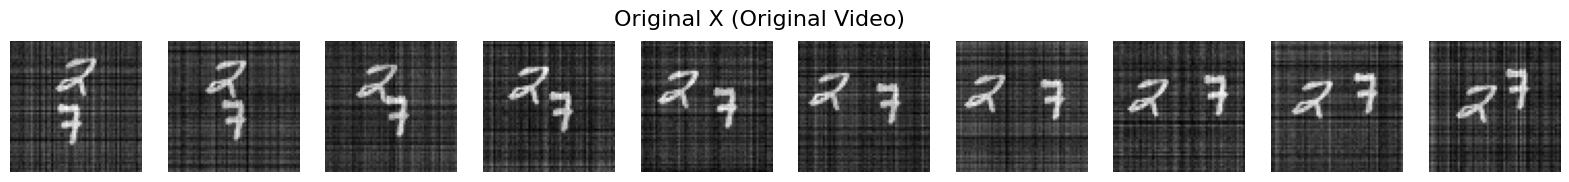

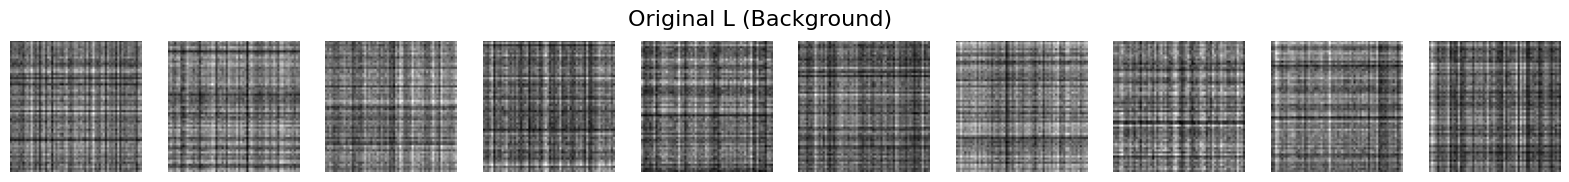

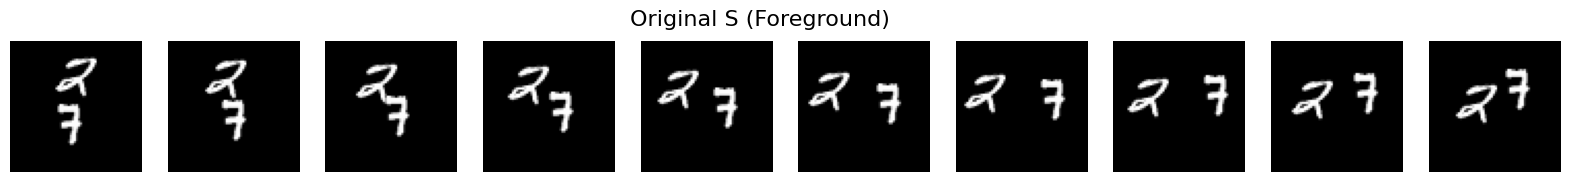



Transformed L_new shape: torch.Size([1, 4096, 10])
Transformed S_new shape: torch.Size([1, 4096, 10])
Transformed X_new shape: torch.Size([1, 4096, 10])


In [140]:
# Display the shape of original data (X)
print("Original X shape:", X.shape)
print("Original L shape:", L.shape)
print("Original S shape:", S.shape)

# Plot the first video frames of original X, L, and S
def plot_video_frames(data, title):
    video_idx = 0  # Selecting the first video (index 0)
    # frames = data[:, video_idx, :, :]  # Shape: (10, 64, 64)

    # If data is 4D, slice the video
    if len(data.shape) == 4:  # Shape: (num_videos, num_frames, height, width)
        frames = data[video_idx]  # Now frames has shape (num_frames, height, width)
    else:
        frames = data  # If data is already in 3D shape

    # Create a figure with 10 subplots (one for each frame)
    num_frames = frames.shape[0]  # Determine the number of frames

    # Create a figure with 10 subplots (one for each frame)
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    fig.suptitle(title, fontsize=16)

    for i in range(10):
        axs[i].imshow(frames[i], cmap='gray')
        axs[i].axis('off')

    plt.show()

# Plot original X, L, and S
print("\nPlots for Original")
plot_video_frames(X, "Original X (Original Video)")
plot_video_frames(L, "Original L (Background)")
plot_video_frames(S, "Original S (Foreground)")

# Simulating transformation via the dataset
# L_new, S_new, X_new represent transformed data after the dataloader
L_new, S_new, X_new = dataset[0]  # Dataset returns transformed tensors

# Display the shape of transformed data (L_new, S_new, X_new)
print("\n")
print("Transformed L_new shape:", L_new.shape)
print("Transformed S_new shape:", S_new.shape)
print("Transformed X_new shape:", X_new.shape)


Now design a neural network with up to 5 layers based on the intuition for low rank and sparse solutions developed above. Each layer should contain two branches for performing proximal operations for the low rank and sparse component respectively.

During training, plot the following:
1. MSE Loss as a function of the number of epochs.
2. Final values of learnt thresholding parameters for the L and S brances as a function of layer number.

For the test data, plot the following two charts by averaging over all points:
1. Low Rank:
  - 3D plot showing layer number and index of singular value on the x and y axes and the singular values themselves on the z axis.

2. Sparse:
  - 2D plot showing layer number on the x axis and number of sparse values on the y axis.

In [141]:
class ISTABlock(nn.Module):
    def __init__(self, branch, kernel_size=3, input_channels=1, output_channels=1, initial_threshold=0.1):
        """
        Initialize the ISTA block with a convolution layer and a learnable threshold.
        """
        super(ISTABlock, self).__init__()
        self.branch = branch

        # Convolutional layer (learnable weights)
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, padding=kernel_size//2)  # Ensuring same output size

        # Learnable threshold parameter
        self.threshold = nn.Parameter(torch.tensor(initial_threshold, dtype=torch.float32))

    def _soft(self, X, thr):
        """Apply soft-thresholding to the input tensor."""
        return torch.sign(X) * torch.maximum(torch.abs(X) - thr, torch.zeros_like(X))

    def _svt(self, X, thr):
        """Apply Singular Value Thresholding (SVT) to the input tensor."""
        batch_size, channels, height, width = X.shape
        X_svt = []

        # Loop through the batch and apply SVD to each 2D matrix
        for i in range(batch_size):
            # Collapse channel and height into a 2D matrix for SVD
            X_flat = X[i].view(channels * height, width)

            U, Sigma, V = torch.svd(X_flat)  # Apply SVD on each 2D matrix

            # Apply thresholding to singular values
            Sigma_thresh = torch.maximum(Sigma - thr, torch.zeros_like(Sigma))

            # Reconstruct the matrix
            reconstructed_matrix = torch.matmul(U, torch.matmul(torch.diag(Sigma_thresh), V.T))

            # Reshape back to original shape
            reconstructed_matrix = reconstructed_matrix.view(channels, height, width)
            X_svt.append(reconstructed_matrix)

        return torch.stack(X_svt)  # Stack back into a 4D tensor


    def forward(self, X):
        """Perform the forward pass through the ISTA block based on the branch type."""
        X_conv = self.conv(X)  # Apply convolution

        if self.branch == 'L':  # Low-rank branch
            return self._svt(X_conv, self.threshold)
        elif self.branch == 'S':  # Sparse branch
            return self._soft(X_conv, self.threshold)
        else:
            raise ValueError(f"Invalid branch type: {self.branch}")


class UnfoldedDNN(nn.Module):
    def __init__(self, configs):
        """
        Initialize the unfolded neural network using the provided configurations.

        Args:
            configs (dict): Configuration dictionary containing parameters like num_layers, kernel_size, etc.
        """
        super(UnfoldedDNN, self).__init__()

        # Extract parameters from configs
        num_layers = configs["num_layers"]
        kernel_size = configs["kernel_size"]
        input_channels = 1  # Assuming 1 input channel (grayscale)
        output_channels = 1  # Assuming 1 output channel (grayscale)

        # Create ISTA blocks for both 'L' (low-rank) and 'S' (sparse) branches
        self.L_blocks = nn.ModuleList([ISTABlock(branch='L', kernel_size=kernel_size, input_channels=input_channels, output_channels=output_channels) for _ in range(num_layers)])
        self.S_blocks = nn.ModuleList([ISTABlock(branch='S', kernel_size=kernel_size, input_channels=input_channels, output_channels=output_channels) for _ in range(num_layers)])

    def get_thresholds(self):
        """Return the thresholds from both branches of the network."""
        L_thresholds = [block.threshold.item() for block in self.L_blocks]
        S_thresholds = [block.threshold.item() for block in self.S_blocks]
        return L_thresholds, S_thresholds

    def forward(self, X):
        """Perform the forward pass through the unfolded neural network and return activations."""
        L = X
        S = X
        activations_L = []
        activations_S = []

        for L_block, S_block in zip(self.L_blocks, self.S_blocks):
            L = L_block(L)
            S = S_block(S)
            activations_L.append(L)
            activations_S.append(S)

        return (activations_L, activations_S), (L, S)


Now Train the Model and evaluate the outputs. Complete the plotting functions and feel free to change the configurations or training settings

In [156]:
def plot_mse_loss(epoch_losses):
    """
    Plot MSE loss over epochs.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(epoch_losses, label='MSE Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('MSE Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_threshold_params(L_params, S_params):
    """
    Plot threshold parameters for L and S branches across layers.
    """
    layers = list(range(1, len(L_params) + 1))

    plt.figure(figsize=(8, 6))

    plt.plot(layers, L_params, label='L Branch Thresholds', marker='o', color='blue')
    plt.plot(layers, S_params, label='S Branch Thresholds', marker='o', color='green')

    plt.xlabel('Layer Number')
    plt.ylabel('Threshold Value')
    plt.title('Threshold Parameters Across Layers')
    plt.legend()
    plt.grid(True)
    plt.show()


def get_singular_values(L_):
    """
    Calculate singular values from the low-rank component.
    """
    batch_size = L_.size(0)
    singular_values_list = []

    # Loop through the batch and apply SVD to each 2D matrix
    for i in range(batch_size):
        _, S, _ = torch.svd(L_[i])  # Apply SVD on each batch element
        singular_values_list.append(S)  # Collect singular values

    return singular_values_list  # Return the list of singular values for each item in the batch


def get_sparsity(S_, tol=1e-6):
    """
    Calculate sparsity (number of non-zero elements with tolerance 10^-6) from the sparse component.
    """
    return (torch.abs(S_) > tol).sum().item()


def plot_singular_values_over_layers(singular_values):
    """
    Plot singular values for each layer as a 3D surface plot.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    num_layers = len(singular_values)
    max_singular_vals = max([len(s) for s in singular_values])

    # Create a meshgrid for plotting
    X = np.arange(1, num_layers + 1)  # Layer number (x-axis)
    Y = np.arange(1, max_singular_vals + 1)  # Singular value index (y-axis)
    X, Y = np.meshgrid(X, Y)

    # Prepare Z matrix (singular values for each layer, padded with zeros if necessary)
    Z = np.zeros_like(X, dtype=np.float32)
    for i in range(num_layers):
        Z[:len(singular_values[i]), i] = singular_values[i].cpu().numpy()

    # Plot the surface
    ax.plot_surface(X, Y, Z.T, cmap='viridis')

    ax.set_xlabel('Layer Number')
    ax.set_ylabel('Singular Value Index')
    ax.set_zlabel('Singular Value')
    ax.set_title('Singular Values Over Layers')

    plt.show()


def plot_sparse_values_over_layers(sparse_values):
    """
    Plot average number of sparse values across layers.
    """
    layers = list(range(1, len(sparse_values) + 1))

    plt.figure(figsize=(8, 6))
    plt.plot(layers, sparse_values, label='Sparse Values', marker='o', color='red')

    plt.xlabel('Layer Number')
    plt.ylabel('Number of Sparse Values')
    plt.title('Sparse Values Across Layers')
    plt.legend()
    plt.grid(True)
    plt.show()


In [160]:
from tqdm import tqdm

def train(model, train_loader, loss_fn, optimizer, configs):
    model.train()
    epoch_losses = []
    L_params = []
    S_params = []

    for epoch in range(configs["epochs"]):
        running_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{configs['epochs']}]", unit="batch") as pbar:
            for L, S, X in pbar:
                L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])
                optimizer.zero_grad()
                _, (L_, S_) = model(X)
                loss = loss_fn(L_, S_, L, S, X)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * L.size(0)
                pbar.set_postfix(loss=running_loss / len(train_loader.dataset))

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)

        thresholds_S, thresholds_L = model.get_thresholds()
        L_params.append(thresholds_L)
        S_params.append(thresholds_S)

        print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

    plot_mse_loss(epoch_losses)
    print("\n")
    plot_threshold_params(L_params, S_params)


def evaluate(model, test_loader, loss_fn, configs):
    model.eval()
    running_loss = 0.0
    all_sparsities = []
    all_singular_values = []

    with torch.no_grad():
        for batch_idx, (L, S, X) in enumerate(test_loader):
            L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])

            # Forward pass through the model
            (activations_L, activations_S), (L_, S_) = model(X)

            # Calculate the loss
            loss = loss_fn(L_, S_, L, S, X)
            running_loss += loss.item() * L.size(0)

            print(f"Plot for random frame in {batch_idx}")
            plot_first_frame(L, S, X)

            # Gather singular values and sparsity for each layer
            batch_singular_values = []
            batch_sparsities = []
            for L_layer, S_layer in zip(activations_L, activations_S):
                singular_values = get_singular_values(L_layer)  # Get singular values
                sparsity = get_sparsity(S_layer.cpu())  # Ensure it's on the CPU
                batch_singular_values.append(singular_values)  # Add singular values directly as a list of tensors
                batch_sparsities.append(sparsity)

            all_singular_values.append(batch_singular_values)
            all_sparsities.append(batch_sparsities)

    avg_loss = running_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.4f}")

    # Handle varying singular value shapes
    max_singular_len = max([len(s) for layer_s in all_singular_values for s in layer_s])

    # Process singular values, converting each tensor in the list to a NumPy array
    avg_singular_values = []
    for layer_s in all_singular_values:
        # Move tensors to CPU before converting to NumPy
        padded_layer_s = [np.pad(s.cpu().numpy(), (0, max_singular_len - len(s)), mode='constant') if isinstance(s, torch.Tensor) else s for s in layer_s]
        avg_singular_values.append(np.mean(padded_layer_s, axis=0))

    avg_sparsities = np.mean(all_sparsities, axis=0)

    # Plot singular values over layers
    plot_singular_values_over_layers(avg_singular_values)

    # Plot sparse values over layers
    plot_sparse_values_over_layers(avg_sparsities)

    return avg_loss


def plot_first_frame(L, S, X):
  L_frame_flat = L[0, 0, :, 0]  # Shape: (4096,)
  S_frame_flat = S[0, 0, :, 0]  # Shape: (4096,)
  X_frame_flat = X[0, 0, :, 0]  # Shape: (4096,)

  L_frame = L_frame_flat.view(64, 64).cpu().numpy()
  S_frame = S_frame_flat.view(64, 64).cpu().numpy()
  X_frame = X_frame_flat.view(64, 64).cpu().numpy()

  fig, axs = plt.subplots(1, 3, figsize=(12, 4))

  axs[0].imshow(L_frame, cmap='gray')
  axs[0].set_title('Background (L)')
  axs[0].axis('off')

  axs[1].imshow(S_frame, cmap='gray')
  axs[1].set_title('Foreground (S)')
  axs[1].axis('off')

  axs[2].imshow(X_frame, cmap='gray')
  axs[2].set_title('Original (D)')
  axs[2].axis('off')

  plt.show()


def loss_fn(L_, S_, L, S, X):
  loss_L = torch.nn.functional.mse_loss(L_, L)
  loss_S = torch.nn.functional.mse_loss(S_, S)
  return loss_L + loss_S


Epoch [1/30]: 100%|██████████| 25/25 [00:05<00:00,  4.41batch/s, loss=0.127]


Epoch: [1/30], Loss: 0.1272


Epoch [2/30]: 100%|██████████| 25/25 [00:05<00:00,  4.28batch/s, loss=0.119]


Epoch: [2/30], Loss: 0.1194


Epoch [3/30]: 100%|██████████| 25/25 [00:06<00:00,  4.16batch/s, loss=0.112]


Epoch: [3/30], Loss: 0.1123


Epoch [4/30]: 100%|██████████| 25/25 [00:05<00:00,  4.43batch/s, loss=0.106]


Epoch: [4/30], Loss: 0.1057


Epoch [5/30]: 100%|██████████| 25/25 [00:06<00:00,  3.88batch/s, loss=0.0997]


Epoch: [5/30], Loss: 0.0997


Epoch [6/30]: 100%|██████████| 25/25 [00:06<00:00,  4.16batch/s, loss=0.0943]


Epoch: [6/30], Loss: 0.0943


Epoch [7/30]: 100%|██████████| 25/25 [00:06<00:00,  3.77batch/s, loss=0.0895]


Epoch: [7/30], Loss: 0.0895


Epoch [8/30]: 100%|██████████| 25/25 [00:05<00:00,  4.51batch/s, loss=0.0855]


Epoch: [8/30], Loss: 0.0855


Epoch [9/30]: 100%|██████████| 25/25 [00:06<00:00,  3.98batch/s, loss=0.0822]


Epoch: [9/30], Loss: 0.0822


Epoch [10/30]: 100%|██████████| 25/25 [00:05<00:00,  4.46batch/s, loss=0.0795]


Epoch: [10/30], Loss: 0.0795


Epoch [11/30]: 100%|██████████| 25/25 [00:05<00:00,  4.36batch/s, loss=0.0772]


Epoch: [11/30], Loss: 0.0772


Epoch [12/30]: 100%|██████████| 25/25 [00:06<00:00,  4.07batch/s, loss=0.0753]


Epoch: [12/30], Loss: 0.0753


Epoch [13/30]: 100%|██████████| 25/25 [00:05<00:00,  4.35batch/s, loss=0.0735]


Epoch: [13/30], Loss: 0.0735


Epoch [14/30]: 100%|██████████| 25/25 [00:06<00:00,  3.97batch/s, loss=0.072]


Epoch: [14/30], Loss: 0.0720


Epoch [15/30]: 100%|██████████| 25/25 [00:05<00:00,  4.51batch/s, loss=0.0706]


Epoch: [15/30], Loss: 0.0706


Epoch [16/30]: 100%|██████████| 25/25 [00:06<00:00,  3.96batch/s, loss=0.0694]


Epoch: [16/30], Loss: 0.0694


Epoch [17/30]: 100%|██████████| 25/25 [00:05<00:00,  4.45batch/s, loss=0.0683]


Epoch: [17/30], Loss: 0.0683


Epoch [18/30]: 100%|██████████| 25/25 [00:05<00:00,  4.24batch/s, loss=0.0673]


Epoch: [18/30], Loss: 0.0673


Epoch [19/30]: 100%|██████████| 25/25 [00:06<00:00,  4.14batch/s, loss=0.0664]


Epoch: [19/30], Loss: 0.0664


Epoch [20/30]: 100%|██████████| 25/25 [00:05<00:00,  4.49batch/s, loss=0.0656]


Epoch: [20/30], Loss: 0.0656


Epoch [21/30]: 100%|██████████| 25/25 [00:06<00:00,  3.90batch/s, loss=0.0649]


Epoch: [21/30], Loss: 0.0649


Epoch [22/30]: 100%|██████████| 25/25 [00:05<00:00,  4.47batch/s, loss=0.0643]


Epoch: [22/30], Loss: 0.0643


Epoch [23/30]: 100%|██████████| 25/25 [00:06<00:00,  3.95batch/s, loss=0.0637]


Epoch: [23/30], Loss: 0.0637


Epoch [24/30]: 100%|██████████| 25/25 [00:05<00:00,  4.47batch/s, loss=0.0633]


Epoch: [24/30], Loss: 0.0633


Epoch [25/30]: 100%|██████████| 25/25 [00:06<00:00,  4.15batch/s, loss=0.0629]


Epoch: [25/30], Loss: 0.0629


Epoch [26/30]: 100%|██████████| 25/25 [00:05<00:00,  4.29batch/s, loss=0.0625]


Epoch: [26/30], Loss: 0.0625


Epoch [27/30]: 100%|██████████| 25/25 [00:05<00:00,  4.19batch/s, loss=0.0622]


Epoch: [27/30], Loss: 0.0622


Epoch [28/30]: 100%|██████████| 25/25 [00:07<00:00,  3.52batch/s, loss=0.062]


Epoch: [28/30], Loss: 0.0620


Epoch [29/30]: 100%|██████████| 25/25 [00:05<00:00,  4.43batch/s, loss=0.0618]


Epoch: [29/30], Loss: 0.0618


Epoch [30/30]: 100%|██████████| 25/25 [00:06<00:00,  3.93batch/s, loss=0.0616]


Epoch: [30/30], Loss: 0.0616


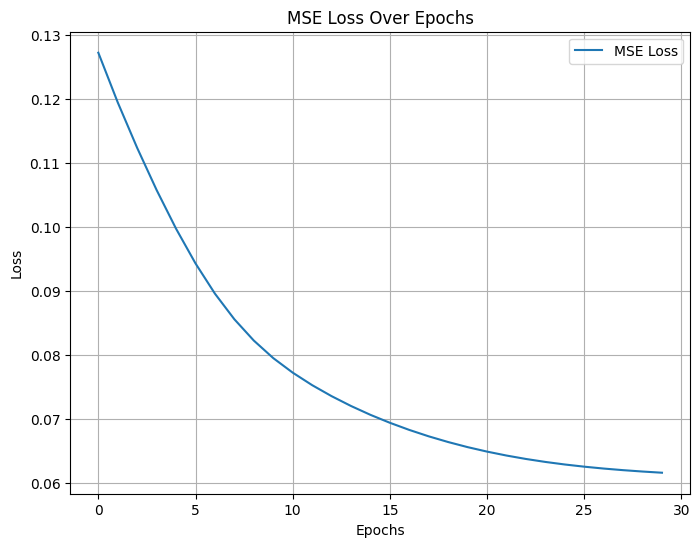

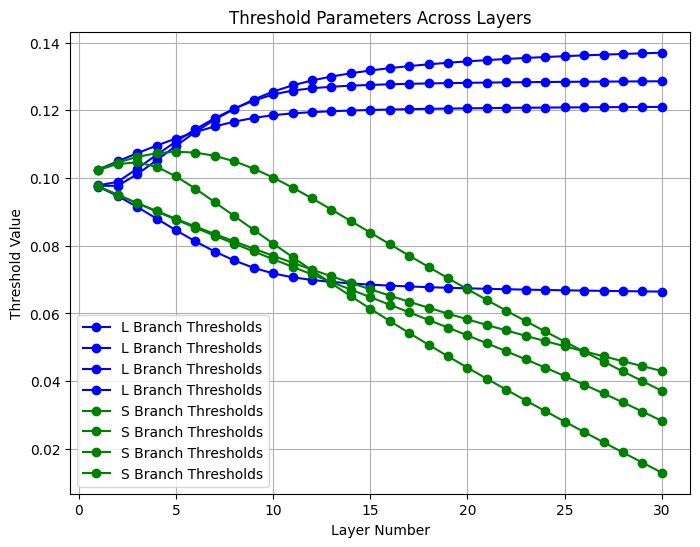

In [158]:
# Model and training configurations
configs = {
    "num_layers": 4,
    "kernel_size": 3,
    "lr": 1e-4,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Initialize the model, optimizer, and datasets
model = UnfoldedDNN(configs).to(configs["device"])
optimizer = Adam(model.parameters(), lr=configs["lr"])

# Train the model
train(model, train_loader, loss_fn, optimizer, configs)

Plot for random frame in 0


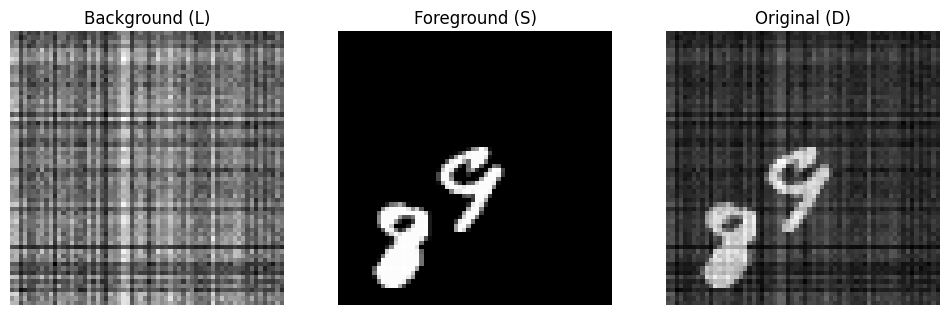

Plot for random frame in 1


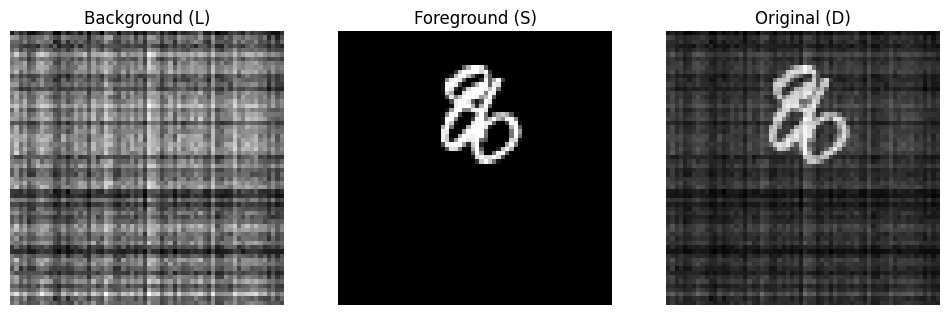

Plot for random frame in 2


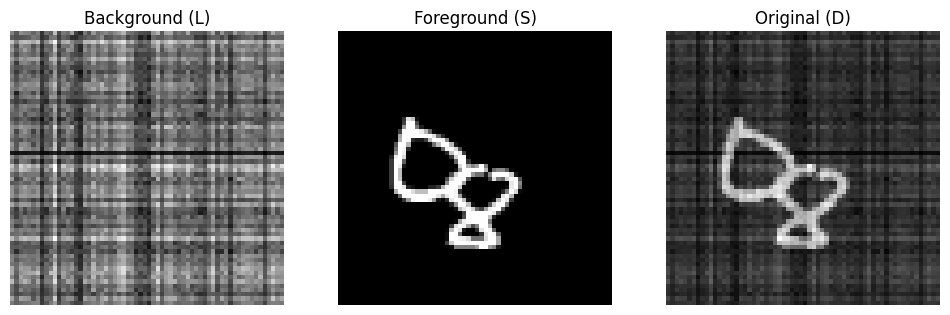

Plot for random frame in 3


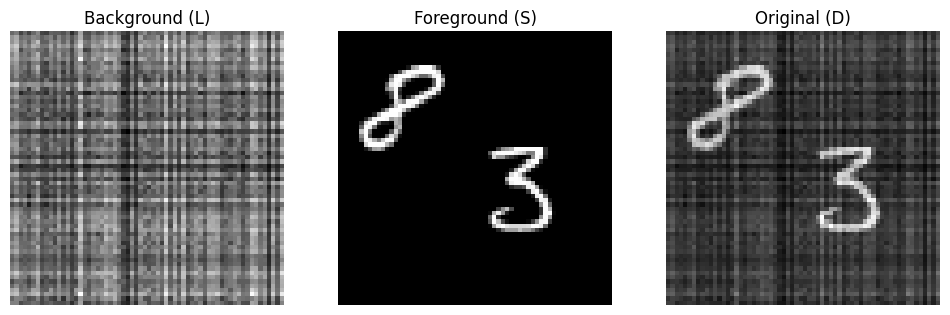

Plot for random frame in 4


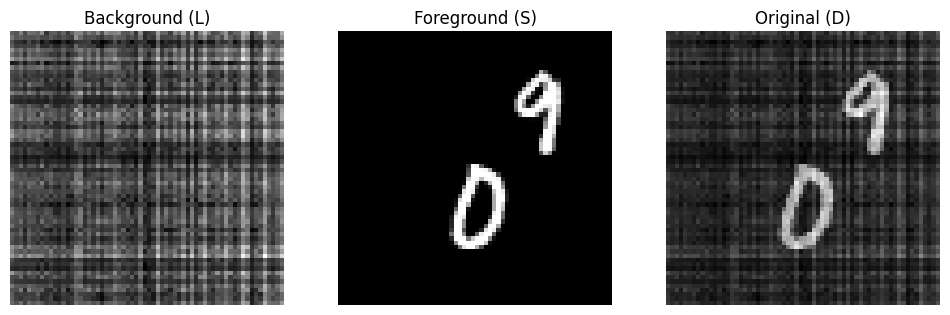

Plot for random frame in 5


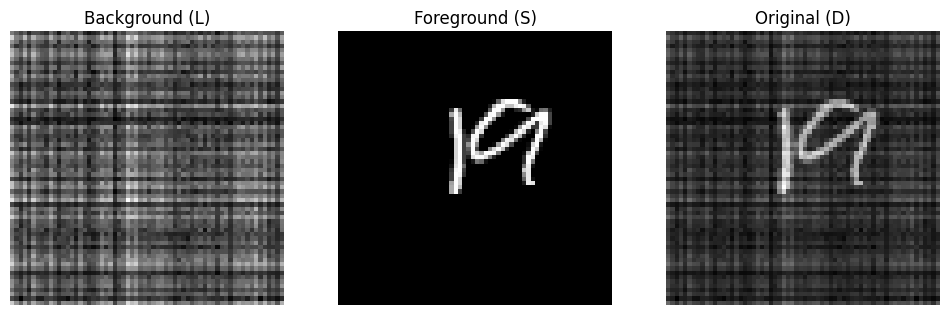

Plot for random frame in 6


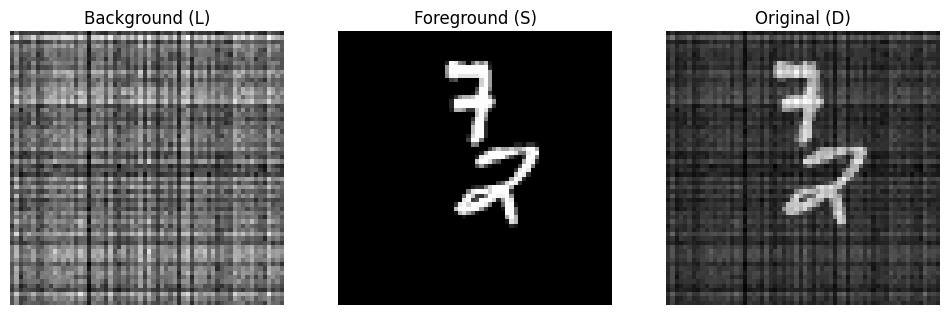

Test Loss: 0.0620


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [161]:
# Evaluate the model
evaluate(model, test_loader, loss_fn, configs)

# Task 5: RPCA with Mixed Norms

Add your solution to this task from the manual in the cells below.